# IMPORTS

In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller

from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import (
    plot_acf,
    plot_pacf
)
from statsmodels.graphics.gofplots import (
    qqplot
)
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error
)

from itertools import product
from typing import (
    Union,
    List,
)
from tqdm import tqdm
import ipywidgets as widgets

# GLOSSARY

## TS Decomposition

**Observed**  
shows the result of combining the Trend, Seasonal, and Residuals

**Trend**  
The trend is the slow-moving changes in a time series.  We can think of the trend component as trying to draw a line through most of the data points to show the general direction of a time series.

**Seasonal**
The seasonal component captures the seasonal variation, which is a cycle that occurs over a fixed period of time.
We can see that over the course of a year, or four quarters, the earnings per share start low, increase, and decrease again at the end of the year.
Notice how the y-axis shows negative values. Does this mean that the earnings per share are negative? Clearly, that cannot be, since our dataset strictly has positive values. Therefore, we can say that the seasonal component shows how we deviate from the trend.

**Residuals**
is what cannot be explained by either the trend or the seasonal components. We can think of the residuals as adding the Trend and Seasonal graphs together and comparing the value at each point in time to the Observed graph. Residuals usually correspond to random errors, also termed white noise,They represent information that we cannot model or predict, since it is completely random


<img src="./images/ts-decomposition.png" width="550" />


**MA(q)** Moving Average model

**AR(p)** Autoregressive model

**ARMA(p,q)** Autoregressive moving average model




## Forcasting

Forecasting is predicting the future using historical data and knowledge of future events that might affect our forecasts.

<img src="./images/f-roadmap.png" width="350" />

**Forecast horizon**

Now you can set the horizon of your forecast. In this case, your camping trip is one
month from now, and it will last for one week. Therefore, you have a horizon of one
week, since you are only interested in predicting the minimum temperature during
the camping trip.

## Baseline

The only way to know that a model is good, or performant, is to compare it to a baseline.

## Out-of-sample Forecasting

Make a predicions for a period that was not taken into account when the model was developed

# CH2 Baselines

- TSF should always start with a baseline model that serves as a bechmark for comparision woth more complex models
- Baseline model is a trivial solution to our forecasting
- 

In [2]:
df= pd.read_csv('datasets/jj.csv')

In [3]:
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


## Decomposition

In [5]:
advanced_decomposition = STL(df['data'], period=4).fit()

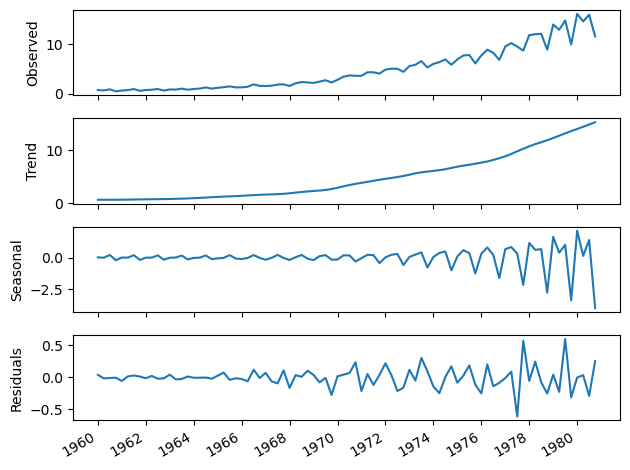

In [6]:
fig, (ax1,ax2,ax3,ax4)= plt.subplots(nrows=4,ncols=1,sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0,81,8),[1960,1962,1964,1966,1968,1970,1972,1974,1976,1978,1980])

fig.autofmt_xdate()
plt.tight_layout()

## Plot data with train/test split

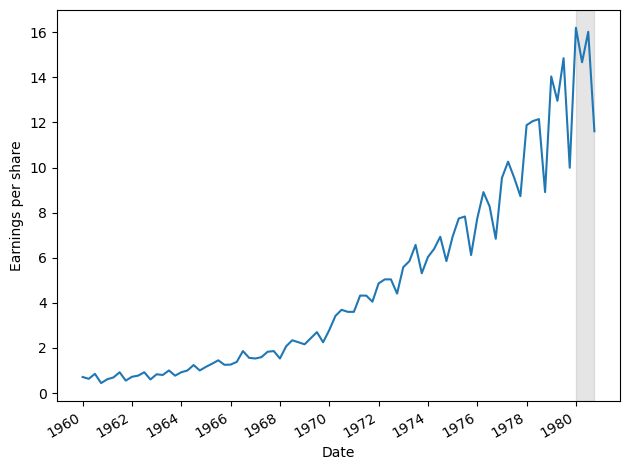

In [7]:
fig, ax= plt.subplots()
ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share')
ax.axvspan(80,83, color='#808080', alpha=.2)
plt.xticks(np.arange(0,81,8),[1960,1962,1964,1966,1968,1970,1972,1974,1976,1978,1980])
fig.autofmt_xdate()
plt.tight_layout()

In [8]:
# Get all except last 4 quarters of 1980
train= df[:-4]

# Get last 4 of 1980 quarters only
test= df[-4:]
print(df.shape, train.shape, test.shape)

(84, 2) (80, 2) (4, 2)


## Historical mean baseline

$
MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{A_i - F_i}{A_i} \right| \times 100
$

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
historical_mean= np.mean(df['data'])
print(f'Historical mean:{historical_mean}')

Historical mean:4.799761892857142


In [11]:
test.loc[: ,'pred_mean'] = historical_mean
mape_hist_mean= mape(test['data'], test['pred_mean'])
print(f'MAPE: {mape_hist_mean}')

MAPE: 66.58773699501253


/tmp/ipykernel_1507/1423054214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[: ,'pred_mean'] = historical_mean


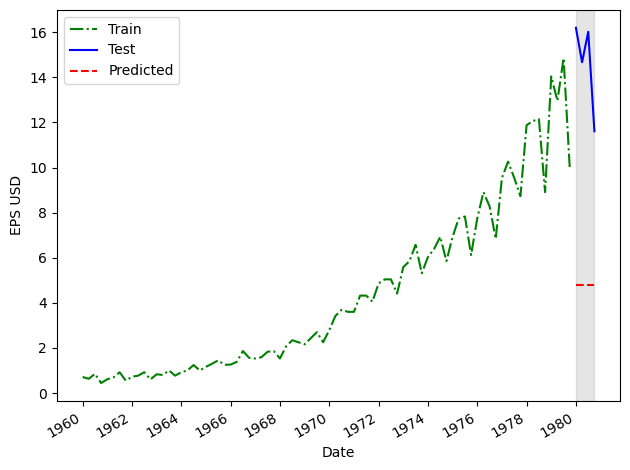

In [12]:
fig, ax=plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_mean'], 'r--', label='Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('EPS USD')
# Highlight forecast horizon
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

**INTERIM CONCLUTION**

MAPE=66% meaning our baseline deviates by 66% frin the observed quarterly EPS

## Last Year Mean

In [13]:
# Last Year mean

last_year_mean= np.mean(train.data[-4:])
print(last_year_mean)

12.96


In [14]:
test.loc[:,'pred_last_yr_mean'] = last_year_mean
mape_last_year_mean= mape(test['data'],test['pred_last_yr_mean'])
print(mape_last_year_mean)

15.5963680725103


/tmp/ipykernel_1507/4254552336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_last_yr_mean'] = last_year_mean


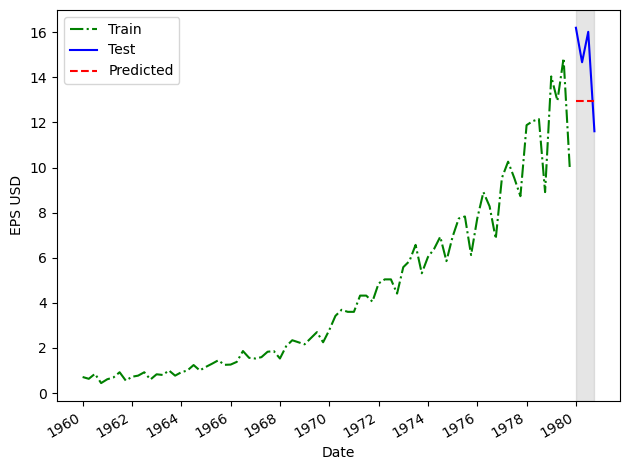

In [15]:
fig, ax=plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_yr_mean'], 'r--', label='Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('EPS USD')
# Highlight forecast horizon
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## Prdicting using the last known value

In [16]:
last = train.data.iloc[-1]
print(last)

9.99


In [17]:
test.loc[:,'pre_last'] = last
mape_last= mape(test['data'],test['pre_last'])
print(mape_last)

30.457277908606535


/tmp/ipykernel_1507/3881234329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pre_last'] = last


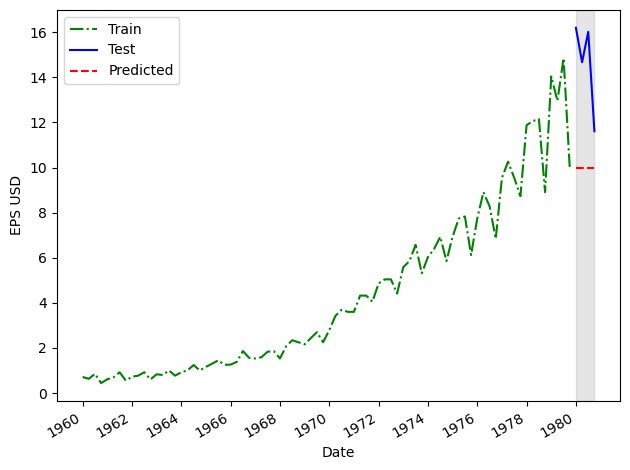

In [18]:
fig, ax=plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pre_last'], 'r--', label='Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('EPS USD')
# Highlight forecast horizon
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

**INTERIM CONCLUSION**

The result is worster the the last year mean because this logick doesn't taking in account a seasonality, which is exists for this dataset

## Naive seasonal forecast

this forcast takes one last observed cycle and repeats in future

In [19]:
test.loc[:,'pred_last_season'] = train['data'][-4:].values 
mape_naive_seasonal = mape(test['data'],test['pred_last_season'])
print(mape_naive_seasonal)

11.561658552433654


/tmp/ipykernel_1507/1335630325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_last_season'] = train['data'][-4:].values


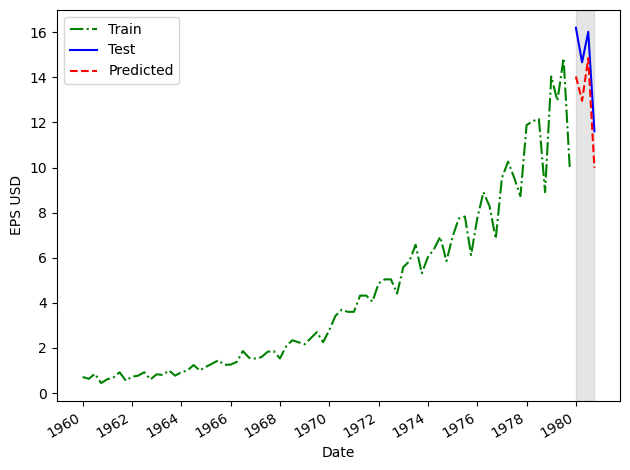

In [20]:
fig, ax=plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_season'], 'r--', label='Predicted')

ax.set_xlabel('Date')
ax.set_ylabel('EPS USD')
# Highlight forecast horizon
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972,1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# STATIONARY TIME SERIES

## CH3 Random Walk

**Definition**  
A random walk is a series whose first difference is stationary and uncorrelated. This means that the process moves completely at random.
<img src="./images/random-walk3.png" width="550" />

<img src="./images/random-walk-1.png" width="350" />

A random walk is a process in which there is an equal chance of going up or down by a random number.

In a random walk process, we say that the present value yt is a function of the value
at the previous timestep yt –1, a constant C, and a random number ϵt, also termed white
noise. Here, ϵt is the realization of the standard normal distribution, which has a variance
of 1 and a mean of 0.

$y_t = C + y_t–1 + ϵ_t$

<img src="./images/random-walk2.png" width="550" />

### Simulate random walk

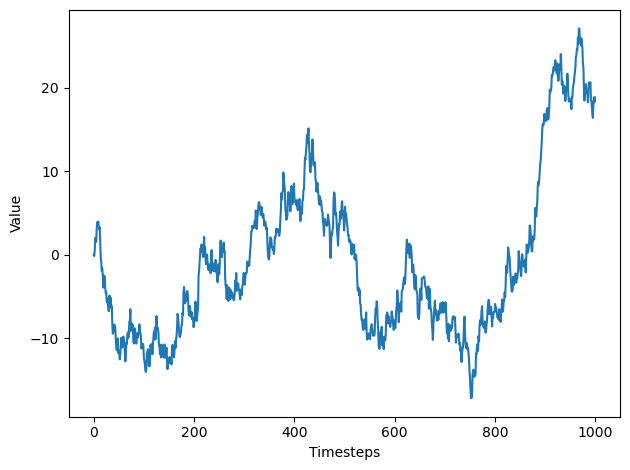

In [21]:
np.random.seed(42)
steps= np.random.standard_normal(1000)
steps[0]=0
random_walk = np.cumsum(steps)
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

### Stationary

A stationary time series is one whose statistical properties do not change over time. In
other words, it has a constant mean, variance, and autocorrelation, and these properties
are independent of time.

A transformation is a mathematical manipulation of the data that stabilizes its mean and variance, thus making it stationary.

Differencing is a transformation that calculates the change from one timestep to
another. This transformation is useful for stabilizing the mean.

<img src="./images/transform1.png" width="550" />

#### Stationarity Test | ADF

##### ADF

- H0: Unit root present in TF
  - The time series will be stationary only if the root lies within the unit circle. Therefore, its value must be between –1 and 1. Otherwise
the series is non-stationary.
- H1: not, and therefor TS is stationary
- p < 0.05 - rject H0

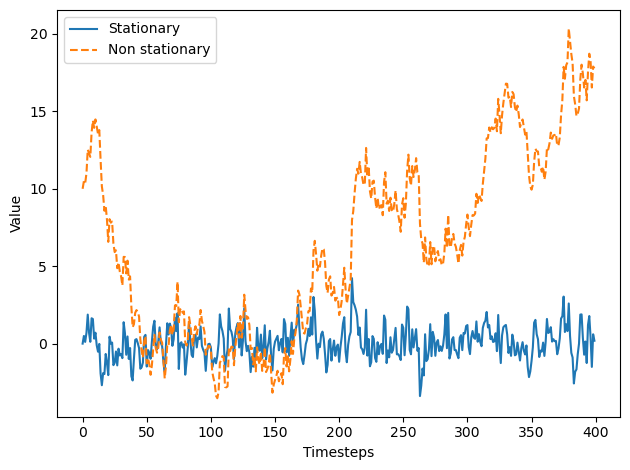

In [22]:
def simulate_process(is_stationary: bool) -> np.array:
    np.random.seed(42)
    process= np.empty(400)

    if is_stationary:
        alpha= 0.5
        process[0]=0
    else:
        alpha=1
        process[0]=10

    for i in range(400):
        if i+1 < 400:
            process[i+1]= alpha * process[i] + np.random.standard_normal()
        else:
            break

    return process

stationary= simulate_process(True)
non_stationary= simulate_process(False)

fig, ax= plt.subplots()
ax.plot(stationary, linestyle='-', label='Stationary')
ax.plot(non_stationary, linestyle='--', label='Non stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc=2)

plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

A stat. series has constant properties over time, meaning  that mean and variance are not function of a time

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


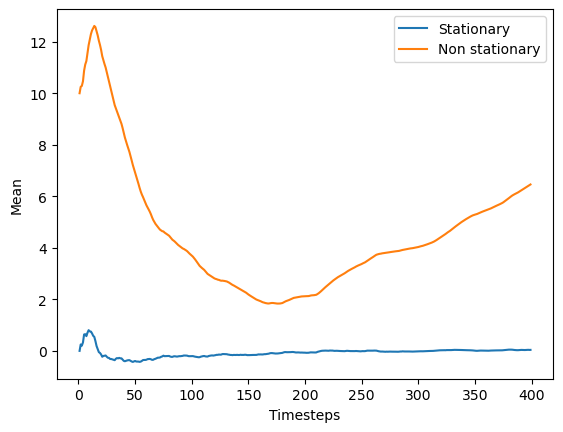

In [23]:
def mean_over_time(process: np.array) -> np.array:
    mean_func= []

    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))

    return mean_func

stat_mean= mean_over_time(stationary)
non_stat_mean = mean_over_time(non_stationary)

fig, ax=plt.subplots()

ax.plot(stat_mean, label='Stationary')
ax.plot(non_stat_mean, label='Non stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean')
ax.legend(loc=1)

plt.show()

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


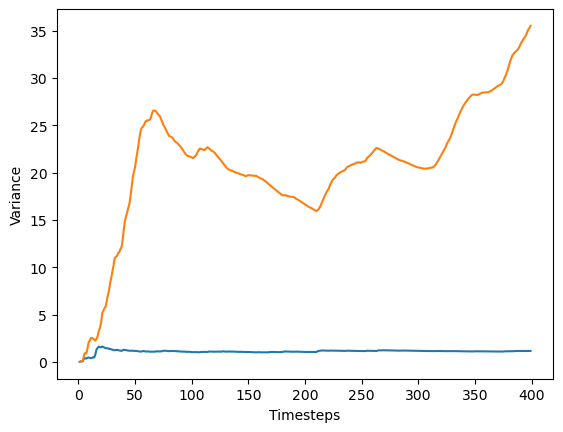

In [24]:
def var_overtime(process: np.array) -> np.array:
    var_func= []

    for i in range(len(process)):
        var_func.append(np.var(process[:i]))

    return var_func

stat_var= var_overtime(stationary)
non_stat_var= var_overtime(non_stationary)

fig, ax= plt.subplots()

ax.plot(stat_var, label='Stationary')
ax.plot(non_stat_var, label='Non stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance')

plt.show()

**INTERIM CONCLUSION**

Once stationary determined we need to determine whethe there is autocorelation or not, to make sure that this is not a random walk whose first difference is stationory and uncorrelated. ADF doesn't show autocorelation

#### Autocorelation | ACF

Autocorelation measures the linear relationship between lagged values of a TS. Another words it measures the corelation of the time series with it self

Lag: the number of timesteps separating by 2 values

### ALL TOGETHER

In [25]:
adf_result=adfuller(random_walk)
print(f'ADF Statistics: {adf_result[0]}')
print(f'p-val: {adf_result[1]}')

ADF Statistics: -0.965952487691875
p-val: 0.7654789696692581


**INTERIM CONCLUSION**

ADF stat is not a large negative val, also p-value is greater the 5% therefor we can not regect H0 thus our TS is not stationary

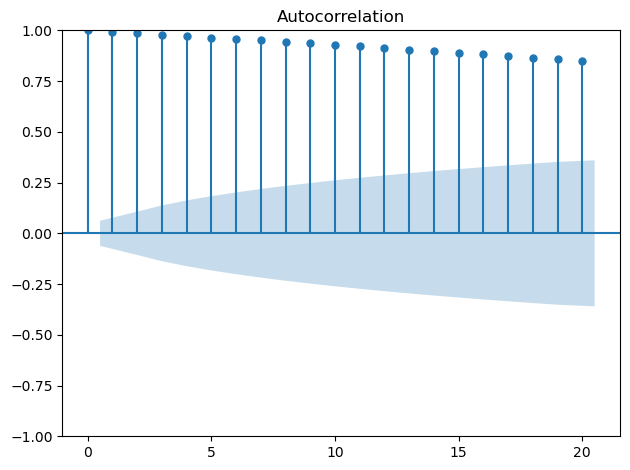

In [26]:
plot_acf(random_walk, lags=20)
plt.tight_layout()

**INTERIM CONCLUSION**

We observe that autocor coef. slowly decreases as the lag increases which is a clear indicator that our random walk is not stationary process.
The shaded area represent confidence interval(доверительный интервал). If the point is in shaded area then it is not signifcatly different from 0(mean random), otherwise the autocor is significant(meaning correlation is present).

We obser stron corelation thus transformation is required in order to retreive usefull information from the ACF

#### Transformation

Since we don't observe seasonal patterns in trend wewill apply a first-order differencing

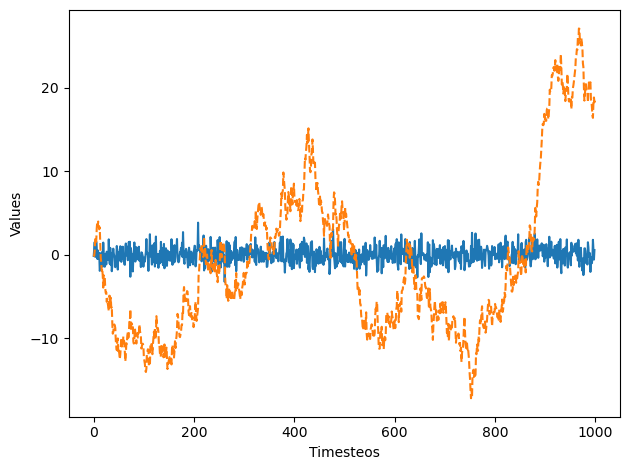

In [27]:
diff_random_walk= np.diff(random_walk,n=1)

fig, ax= plt.subplots()
ax.plot(diff_random_walk, label='Differencing')
ax.plot(random_walk,linestyle='--', label='Original')
ax.set_xlabel('Timesteos')
ax.set_ylabel('Values')
plt.tight_layout()
plt.show()

ADF result: -31.7893108575606, p-val:0.0


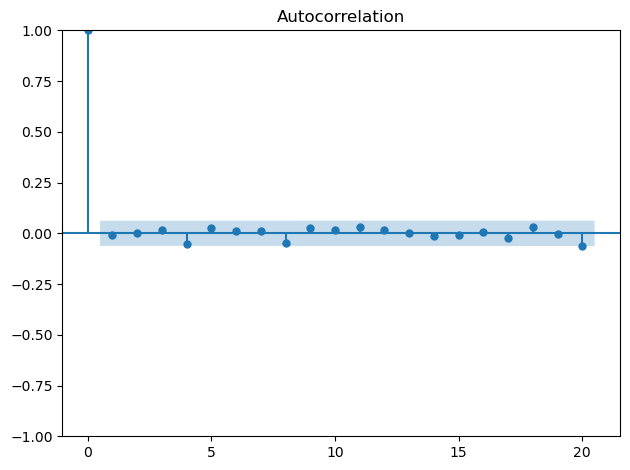

In [28]:
adf_result= adfuller(diff_random_walk)
print(f'ADF result: {adf_result[0]}, p-val:{adf_result[1]}')

plot_acf(diff_random_walk, lags=20)
plt.tight_layout()

**INTERIM CONCLUSION**

The Timeseries has been successfully transformed. Non stationarity removed, thus H0 can be rejected, as process doesn't have a unit root.
There is nomore significant autocorrelation exists after lag 0, this means a stationary process is compleetly random and can be described as a white noise

Thus we has demostrated that our timeseries after transformation applied is a random walk, as series become a stationary  and uncorrelated after a first-order transform has been applied

### PLAY WITH GOOGL

In [29]:
# conda install -c forge yfinance
ticker='GOOGL'
start_date= '2020-04-27'
end_date='2021-04-27'

googl_finslice_df= yf.download(ticker,start_date,end_date) 
googl_finslice_df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2020-04-27,63.313480,63.542999,64.705002,63.252998,64.599998,44186000
2020-04-28,61.406898,61.629501,64.237999,61.519001,64.160004,80700000
2020-04-29,66.866600,67.109001,68.007500,66.336502,67.250000,108358000
2020-04-30,67.091782,67.334999,67.500000,66.074997,66.568001,55842000
2020-05-01,65.628090,65.865997,67.571503,65.483002,66.204498,48872000


**DATA STRUCTURE**

Index: Dates (trading days).

Columns:
- `Open`: Opening price of the stock.
- `High`: Highest price during the day.
- `Low`: Lowest price during the day.
- `Close`: Closing price of the stock.
- `Adj Close`: Adjusted closing price (accounts for splits, dividends, etc.).
- `Volume`: Number of shares traded.

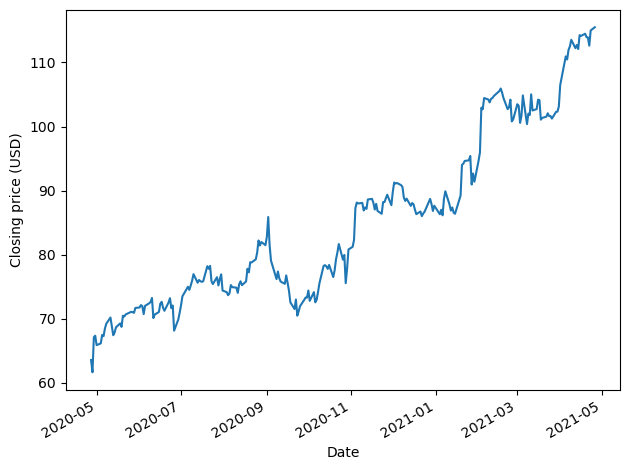

In [30]:
fig, ax= plt.subplots()

ax.plot(googl_finslice_df.index, googl_finslice_df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

We observer that the trend and closing price is increasing therefore the process in non stationary. This further should be confirmed by ADF test

#### Transformation

In [31]:
ADF_GOOGL_res= adfuller(googl_finslice_df['Close'])

print(f'ADF stat:{ADF_GOOGL_res[0]}, p-val:{ADF_GOOGL_res[1]}')

ADF stat:0.31837760731397025, p-val:0.978172106366102


In [32]:
close_prices = googl_finslice_df[('Close', 'GOOGL')]
diff_close = np.diff(close_prices, n=1)

In [33]:
diff_close[:5]

array([-1.91349792,  5.47949982,  0.22599792, -1.46900177,  0.27899933])

In [34]:
ADF_GOOGL_res=adfuller(diff_close)

print(f'ADF stat:{ADF_GOOGL_res[0]}, p-val:{ADF_GOOGL_res[1]}')

ADF stat:-5.263208793484012, p-val:6.522976108151055e-06


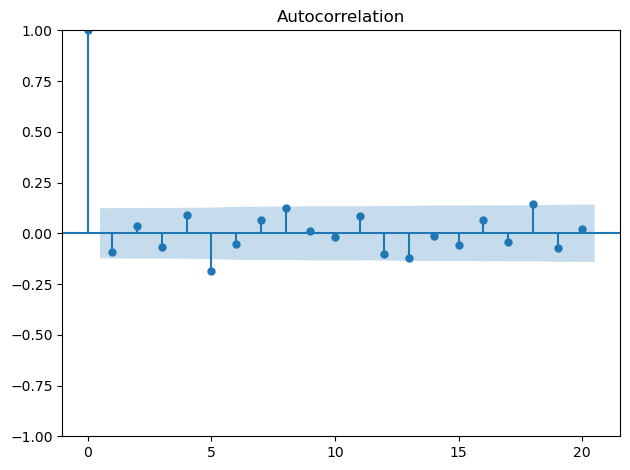

In [35]:
plot_acf(diff_close,lags=20)
plt.tight_layout()


**INTERIM CONCLUSION**

We do not see any significant correlations except lag 5 and 18, but because we do not have any consecuteive significant coefs we can safelly assume that these coefs are not signif9icant. 

Therefore we can conclude that that closing prices can be approximated by a random walk process

#### Forcast

Important to know that predict random walk is impossible. It is same as we woulfd try to predict random values. Therefore we can use naive forcasting methods or baselines.

Since the values changed randomly no stat models can be applied. 
We can only reasonably predict historical mean or last value

**Forcast on long horizon**

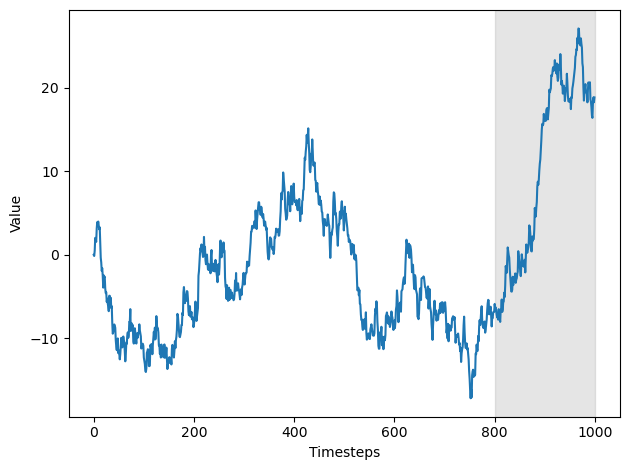

In [36]:
df= pd.DataFrame({'value': random_walk})

train_df= df[:800]
test_df=df[800:]

fig, ax= plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.axvspan(800,1000, color='#808080', alpha=.2)
plt.tight_layout()
plt.show()

**MEAN FORCAST**

In [37]:
mean= np.mean(train_df.value)

test_df.loc[:,'pred_mean']=mean
test_df.head()

/tmp/ipykernel_1507/3324397271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'pred_mean']=mean


,value,pred_mean
800,-5.876664,-3.677206
801,-6.392708,-3.677206
802,-6.296588,-3.677206
803,-6.758863,-3.677206
804,-7.193359,-3.677206


**LAST VALUE FORECAST**

In [38]:
last_val= train_df.iloc[-1].value
test_df.loc[:,'pred_last']= last_val
test_df.head()

/tmp/ipykernel_1507/1572902736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'pred_last']= last_val


,value,pred_mean,pred_last
800,-5.876664,-3.677206,-6.814947
801,-6.392708,-3.677206,-6.814947
802,-6.296588,-3.677206,-6.814947
803,-6.758863,-3.677206,-6.814947
804,-7.193359,-3.677206,-6.814947


**DRIFT FORECAST**

$
    \text{drift}= \frac{\Delta{y}}{\Delta{x}} 
$

In [39]:
delta_x= 800 - 1
delta_y= last_val - 0
drift = delta_y / delta_x

In [40]:
x_vals= np.arange(801,1001, 1)
pred_drift= drift * x_vals
test_df.loc[:, 'pred_drift']= pred_drift
test_df.head()

/tmp/ipykernel_1507/3464275748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'pred_drift']= pred_drift


,value,pred_mean,pred_last,pred_drift
800,-5.876664,-3.677206,-6.814947,-6.832006
801,-6.392708,-3.677206,-6.814947,-6.840536
802,-6.296588,-3.677206,-6.814947,-6.849065
803,-6.758863,-3.677206,-6.814947,-6.857594
804,-7.193359,-3.677206,-6.814947,-6.866124


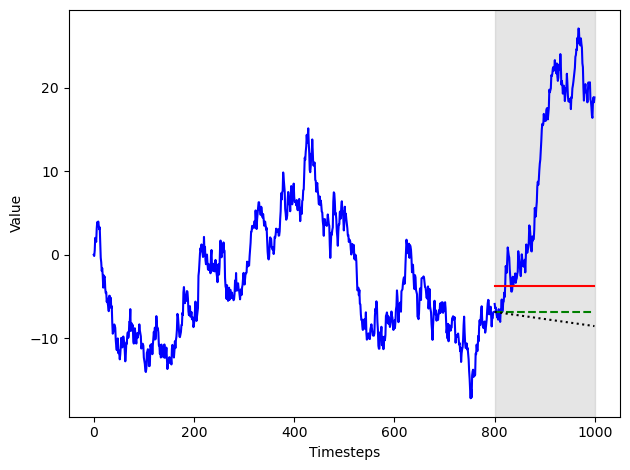

In [41]:
fig,ax= plt.subplots()

ax.plot(train_df.value, 'b-')
ax.plot(test_df.value, 'b-')
ax.plot(test_df.pred_mean, 'r-')
ax.plot(test_df.pred_last, 'g--')
ax.plot(test_df.pred_drift, 'k:')

ax.axvspan(800,1000, color='#808080', alpha=.2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()
plt.show()

**Calculate Loss**

In [42]:
mse_mean= mean_squared_error(test_df.value, test_df.pred_mean)
mse_last= mean_squared_error(test_df.value, test_df.pred_last)
mse_drift= mean_squared_error(test_df.value, test_df.pred_drift)

print(f'MSE mean:{mse_mean}, MSE last:{mse_last}, MSE drift:{mse_drift}')

MSE mean:326.50277395297474, MSE last:425.1726033055617, MSE drift:466.2172769077409


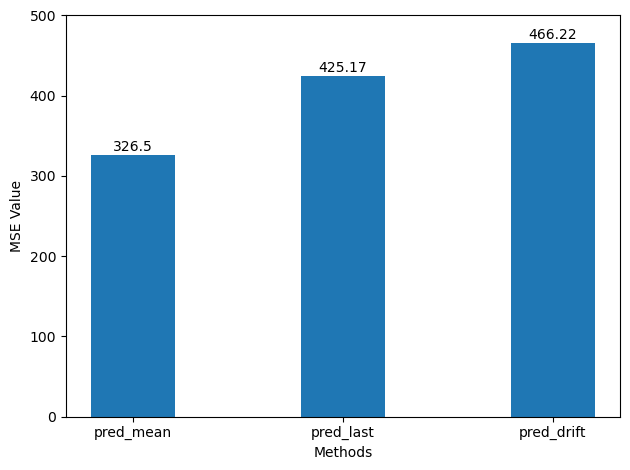

In [43]:
x= ['pred_mean', 'pred_last', 'pred_drift']
y= [mse_mean, mse_last, mse_drift]

fig, ax= plt.subplots()
ax.bar(x,y, width=.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE Value')
ax.set_ylim(0,500)

for i, v in enumerate(y):
    plt.text(x=i,y=v+5,s=str(round(v,2)),ha='center')

plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

The best performance has been demonstrated by the historical mean, yet the value over 300 as our simulated random walk value does not exceed 30. Therefore forecasring a random walk on a long horizon doesn't make sence

**Forcasting next timestep**

<img src="./images/forecast-next-timestep.png" width="550" />

Forcasting the next timestep of a random walk is the only reasonable sitiation we can go.

Future val of random walk is the past val + white noise

In [44]:
# forecast next timestep i.e. periods=1
df_shift= df.shift(periods=1)
df_shift.head()

,value
0,NaN
1,0.000000
2,-0.138264
3,0.509424
4,2.032454


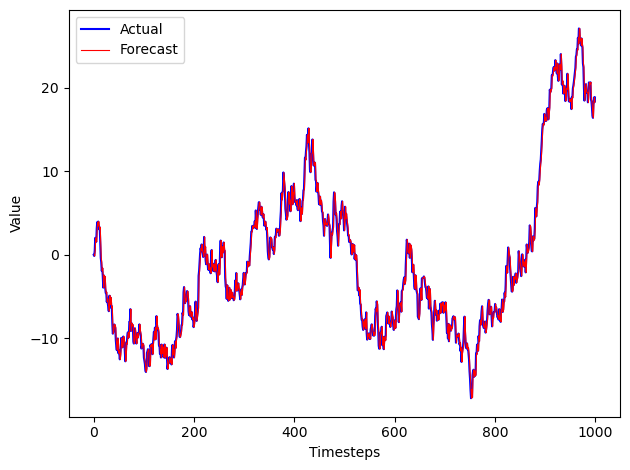

In [45]:
fig, ax= plt.subplots()

ax.plot(df,'b-', label='Actual')
ax.plot(df_shift,'r-', linewidth=.8, label='Forecast')
ax.legend(loc=2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

In [46]:
test

,date,data,pred_mean,pred_last_yr_mean,pre_last,pred_last_season
80,1980-01-01,16.20,4.799762,12.96,9.99,14.04
81,1980-04-01,14.67,4.799762,12.96,9.99,12.96
82,1980-07-02,16.02,4.799762,12.96,9.99,14.85
83,1980-10-01,11.61,4.799762,12.96,9.99,9.99


In [47]:
mse_one_step= mean_squared_error(test_df['value'], df_shift[800:])

mse_one_step

0.9256876651440581

**Zoom In**

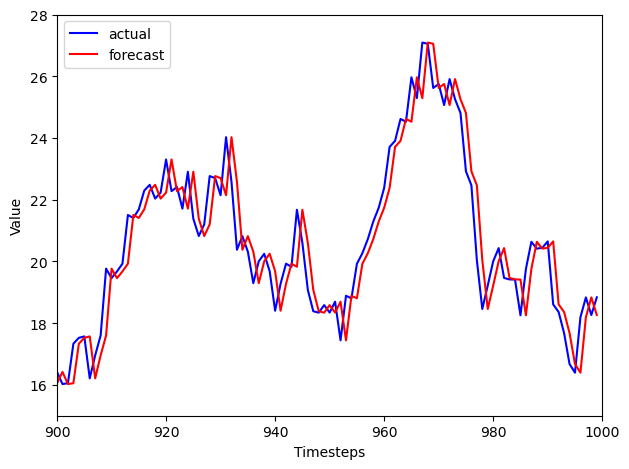

In [48]:
fig, ax= plt.subplots()

ax.plot(df,'b-',label='actual')
ax.plot(df_shift,'r-', label='forecast')
ax.legend(loc=2)

ax.set_xlim(900,1000)
ax.set_ylim(15,28)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

## CH4 Modeling MA(q) (Moving Average)

In a MA process the current value depends linearly on the mean of the series, the current error term and past error terms

**MA(q) model** 
- states that the current value is linearly dependent on the current and past error terms. The error terms are assumed to be mutualy independednt and normaly distributed just like white noise.
- q: is the order
- the modele express the present value as a linear combination of the:
  - $\mu$ : mean of the seris
  - $\epsilon_t$ : the present error
  - $\epsilon_t-_q$ : past error term
  - $\theta_q$ : magnitude of the impact of past errors on the present value

MA(q) $y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots +\theta_q\epsilon_{t-q}$

<img src="./images/MA-1.png" width="550" />


4-1 Figure shows long-term trend with Peaks and troughts. It is not a stationary process since we can not observe a trend overtime, furthermore there is no apparent cyclical pattern in the data so we can rule out any seasonal effects for now. 

### 1. Identify the order

In [49]:
df= pd.read_csv('./datasets/widget_sales.csv')
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


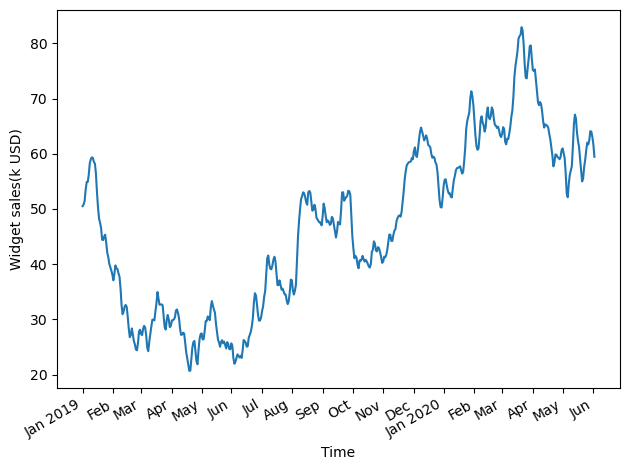

In [50]:
fig, ax= plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales(k USD)')
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

# Tilt the labels ib the x-axis ticks so that they display nicely
fig.autofmt_xdate()
# Remove extra whitespaces around the figure
plt.tight_layout()
plt.show()

#### 1.1 Test for stationarity

On the figure abouve it is obvious that there is no stattionarity as there is no observable trend, hovewer we must make sure

In [51]:
ADF_result= adfuller(df['widget_sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069358996
p-value: 0.5274845352272631


**INTERIM CONCLUSION**

The ADF stat is not large negative number, and p-val is above 0.05, therefore our timeline is not stationary and we must apply transformations to make it stationary

#### 1.2. Transformations

In this example we will stabilize the trand by applying firs-order diff

In [52]:
# n=1 because it is first order diff
widget_sales_diff= np.diff(df['widget_sales'], n=1)

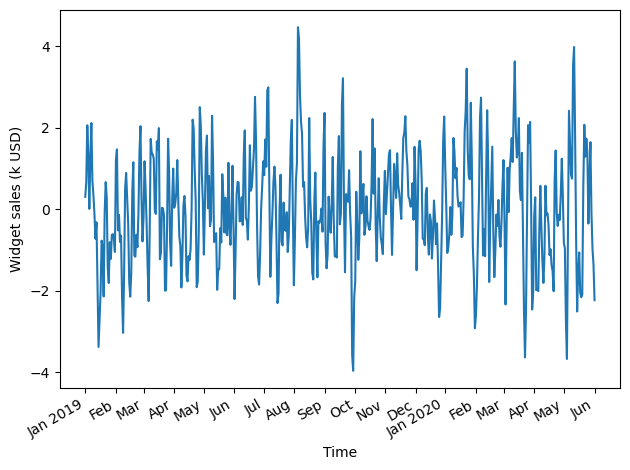

In [53]:
fig, ax= plt.subplots()
ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k USD)')
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [54]:
ADF_result= adfuller(widget_sales_diff)

print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-val: {ADF_result[1]}')

ADF Statistics: -10.576657780341957
p-val: 7.076922818587346e-19


#### 1.3 Plot ACF

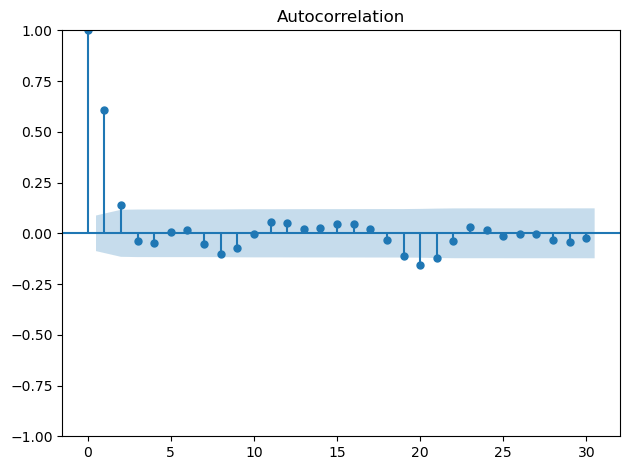

In [55]:
plot_acf(widget_sales_diff, lags=30)
plt.tight_layout()

**INTERIM CONCLUSION**

The ADF stat is relitevly large negative value, p-val is less the 0.05, also we can see on figure that long-term trend has been removed as all values are hovering around 0. On a ACF plot we observe significant coefs up untill 2, anf then they are abruptly become insignificant as they a re remain in shaded area. All above means that we have a stationary moving average model MA(2)(i.e the order of MA is 2) to forecast out stationary time series.

### 2. Forcast MA 

When using an MA(q) model, forecasting beyond q steps into the future will simply
return the mean, because there are no error terms to estimate beyond q steps. Thus we
should use rolling forecasts to predict up to q steps at a time in order avoid predicting
only the mean of the series.

In [56]:
# Split data on train and test
df_diff= pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train_df= df_diff[:int(.9 * len(df_diff))] # 90% to train
test_df= df_diff[int(.9 * len(df_diff)):] # 10% to test

# Note that original dataset has 500 datapoints but our diff has onluy 499 since we have diff once
print(f'train_df: {train_df.shape}')
print(f'test_df: {test_df.shape}')

train_df: (449, 1)
test_df: (50, 1)


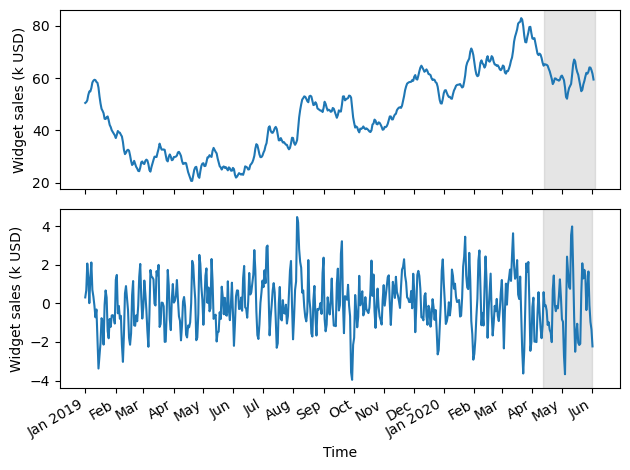

In [57]:
# Visualuze the forecasting period for the difference and orogonal series

# Make 2 subplots insude same figure
fig, (ax1, ax2)= plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k USD)')
ax1.axvspan(450,500, color='#808080', alpha=.2)

ax2.plot(widget_sales_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales (k USD)')
ax2.axvspan(449, 498, color='#808080', alpha=.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [58]:
# A function for rolling forecast on a horizon

import numpy as np
from pandas import DataFrame
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import t  # Assuming you'll need it later for confidence intervals

def rolling_forecast(df: DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    """
    Perform rolling forecasts on a time series DataFrame using different methods:
    - Mean of the observed data
    - Last observed value
    - Moving Average (MA) model of order (0, 0, 2)

    Parameters
    ----------
    df : DataFrame
        The time series data as a Pandas DataFrame with a single column of numeric values.
    train_len : int
        The initial number of data points used to fit the model.
    horizon : int
        The number of future data points to predict (test set length).
    window : int
        The number of timesteps predicted in each iteration (forecast window size).
    method : str
        The forecasting method to use:
        - 'mean': Forecast using the mean of the training data.
        - 'last': Forecast using the last observed value.
        - 'MA': Forecast using a Moving Average (MA) model.

    Returns
    -------
    list
        A list of predicted values for the specified horizon.

    Raises
    ------
    ValueError
        If an unsupported method is provided.
    """
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            # Calculate mean of data up to the current point
            mean = np.mean(df[:i].values)
            # Extend the mean prediction for the length of the window
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            # Take the last observed value as the prediction
            last_value = df[:i].iloc[-1].values[0]
            # Extend the last value prediction for the length of the window
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value

    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            # Fit a Moving Average model of order (0, 0, 2)
            model = SARIMAX(df[:i], order=(0, 0, 2))
            res = model.fit(disp=False)
            # Get predictions for the next `window` steps
            predictions = res.get_prediction(start=i, end=i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            # Extend the out-of-sample predictions for the window size
            pred_MA.extend(oos_pred)
        return pred_MA

    else:
        raise ValueError(f"Unsupported forecasting method: {method}")

In [59]:
%%time
TRAIN_LEN= len(train_df)
HORIZON= len(test_df)
WINDOW=2

pred_df= test_df.copy()

pred_df['pred_mean']= rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_df['pred_last_val']= rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_df['pred_MA']= rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df.head()

CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 441 ms


,widget_sales_diff,pred_mean,pred_last_val,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


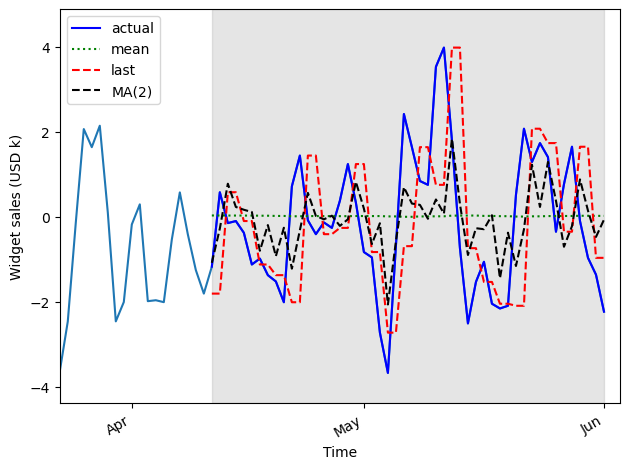

In [60]:
fig, ax= plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_val'], 'r--', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (USD k)')

ax.axvspan(449, 498, color='#808080', alpha=.2)
ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

- prediction coming from the historical mean, shown as a dotted line, is almost a straight line. This is expected as the process is stationary, so the historical mean should be stable over time

### 3. Measure models performance

In [61]:
mse_mean= mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last= mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_val'])
mse_MA= mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(f'MSE mean:{mse_mean}, MSE last:{mse_last}, MSE MA(2):{mse_MA}')

MSE mean:2.5606299456880537, MSE last:3.2494260812249225, MSE MA(2):1.9481714497788523


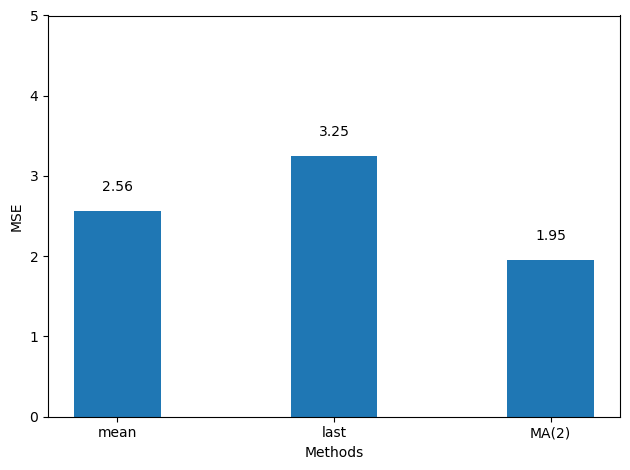

In [62]:
x= ['mean', 'last', 'MA(2)']
y= [mse_mean, mse_last, mse_MA]

fig, ax= plt.subplots()
ax.bar(x, y, width=.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0,5)

for i, v in enumerate(y):
    plt.text(x=i, y=v + .25, s=str(round(v,2)), ha='center')

plt.tight_layout()
plt.show()


**INTERIM CONCLUSION**

MA(2) model is the best-performing forecasting method, since its MSE is the lowest of the three methods. This is expected,
because we previously identified a second-order moving average process for the differenced
volume of widget sales, thus resulting in a smaller MSE compared to the
naive forecasting methods. 

### 4. Inverse transform

<img src="./images/fo-diff.png" width="500"/>

- we need to inversetransform our predictions to bring them back to the original scale of the untransformed dataset.

- In order to reverse our first-order difference, we need to add an initial value y0 to the first differenced value y'1

- to obtain our predictions in the original scale of our dataset, we need to use the first value of the test as our initial value. Then we can perform a cumulative sum to obtain a series of 50 predictions in the original scale of the dataset. We will assign these predictions to the pred_widget_sales column.

In [63]:
# init empty column to hold pred
df['pred_widget_sales']= pd.Series()

# Inverse transform the predictions to bring them back to the original scale of dataset
df['pred_widget_sales'][450:]= df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

/tmp/ipykernel_1507/2104859232.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_widget_sales'][450:]= df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()
/tmp/ipykernel_1507/2104859232.py:5: SettingWithCopyWarning: 
A valu

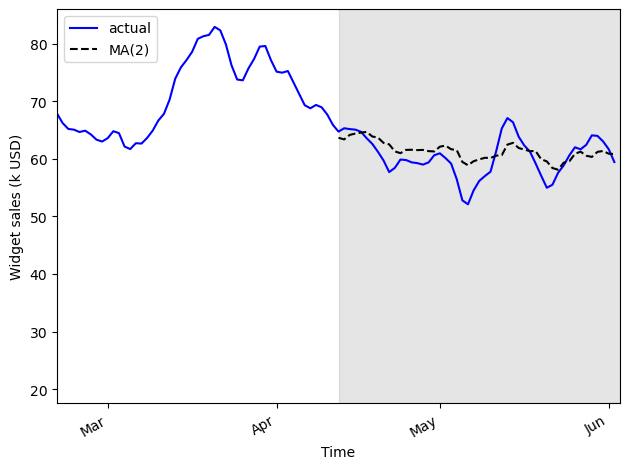

In [64]:
fig, ax= plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k USD)')

ax.axvspan(450,500, color='#808080', alpha=.2)
ax.set_xlim(400,500)
plt.xticks(
[409, 439, 468, 498],
['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### 5. Report Errors

In [65]:
mae_MA_undiff= mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(f'MAE MA(2) undiff: {mae_MA_undiff}')

MAE MA(2) undiff: 2.3244709245355


**INTERIM CONCLUSION**

MAE of 2.32. Therefore, our predictions are, on average, off by $2,320, either above or below the actual value. Notice that our data has units of thousands of dollars, so we multiply the MAE by 1,000 to express the average absolute difference.

## CH5 Modeling AR(p) (Autoregressive Process)


An autoregressive process is denoted as an AR(p) process, where p is the order establishes that the output variable depends linearly on its own previous values. In other words, it is a regression of the variable against itself.
- In such a process, the present value yt is a linear combination of a constant C, the present
error term ϵt, which is also white noise, and the past values of the series yt–p. The magnitude
of the influence of the past values on the present value is denoted as φp, which
represents the coefficients of the AR(p) model. Mathematically, we express a general
AR(p) model with equation 
$\gamma_t = C +\phi_1 \gamma_t–_1 + \phi_2 \gamma_t–_2 + \cdot \phi_p \gamma_t–_p + \epsilon_t$
- the order p of an autoregressive process determines
the number of past values that affect the present value. If we have a first-order
autoregressive process, also denoted as AR(1), then the present value yt is only dependent
on a constant C, the value at the previous timestep φ1yt –1, and some white noise
ϵt, as shown in equation
- the random walk is a special
case of an autoregressive process, where the order p is 1 and φ1 is equal to 1.

Steps to identify the order $p$ of an AR process

<img src="./images/ar-1.png" width="350" />

In [66]:
df= pd.read_csv('./datasets/foot_traffic.csv')
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


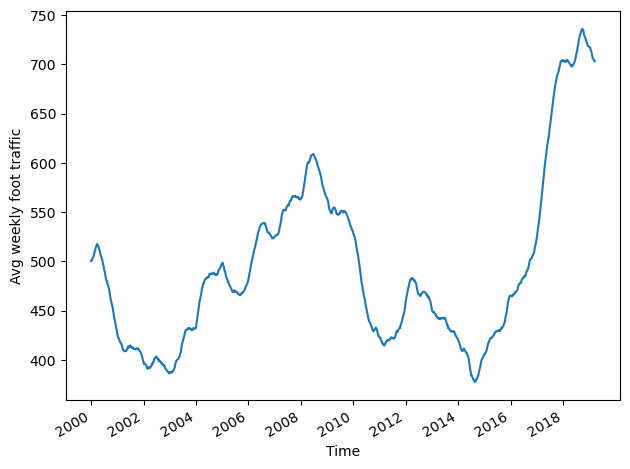

In [67]:
fig, ax= plt.subplots()
ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Avg weekly foot traffic')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

- there is no cyclical pattern, so we can rule out the presence of seasonality.
- trend, it is sometimes positive and sometimes negative throughout the years, with the most recent trend being positive, since 2016. the presence of a trend means that series is likely non-stationary.

### 1. Check for Stationarity

- H0: Unit root present in TF
  - The time series will be stationary only if the root lies within the unit circle. Therefore, its value must be between –1 and 1. Otherwise
the series is non-stationary.
- H1: not, and therefor TS is stationary
- p < 0.05 - rject H0

In [68]:
ADF_result= adfuller(df['foot_traffic'])

print(f'ADF stat: {ADF_result[0]:.2f}')
print(f'p-val: {ADF_result[1]:.2f}')

ADF stat: -1.18
p-val: 0.68


**INTERIM CONCLUSION**

the ADF statistic is not a large negative number, and it has a p-value greater than 0.05, we cannot reject the H0 and our series is therefore non-stationary. Hence, we must apply a transformation to make it stationary.

### 2. Transformation

To remove the effect of the trend and stabilize the mean of the series, we will use differencing.

In [69]:
foot_traffic_diff= np.diff(df['foot_traffic'], n=1)

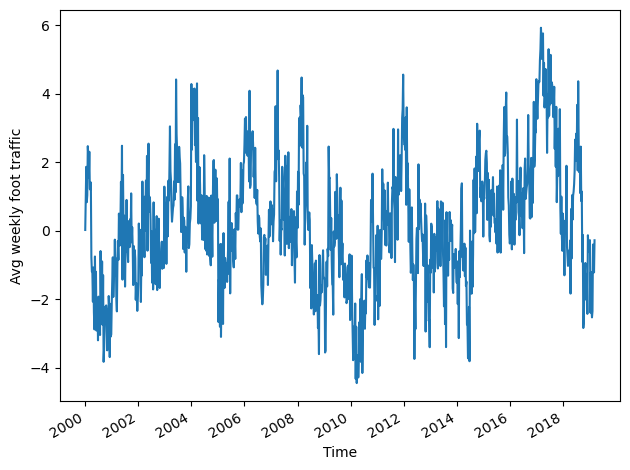

In [70]:
fig,ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Avg weekly foot traffic')
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

long-term trend has been removed, since the series starts and finishes roughly at the same value.

In [71]:
ADF_result= adfuller(foot_traffic_diff)

print(f'ADF stat: {ADF_result[0]:.2f}')
print(f'p-val: {ADF_result[1]:.2f}')

ADF stat: -5.27
p-val: 0.00


**INTERIM CONCLUSION**

With a p-value smaller than 0.05, we can reject the null hypothesis, meaning that we now have a stationary series.

#### Test for Autocorelation

#### ACF

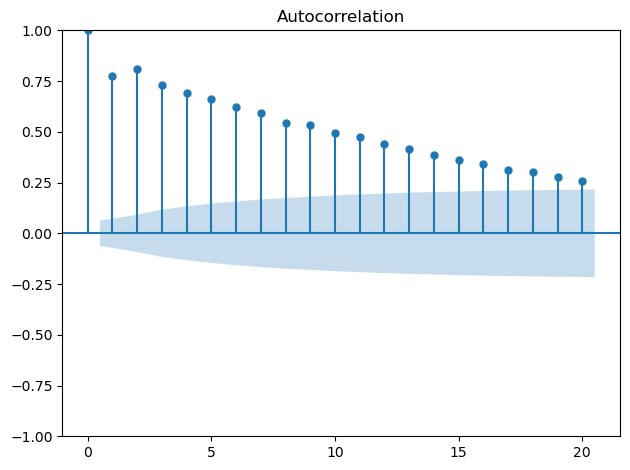

In [72]:
plot_acf(foot_traffic_diff, lags=20)
plt.tight_layout()

**INTERIM CONCLUSION**

- we observe significant autocorrelation coefficients beyond lag 0. Therefore, we know that our process is not a random walk. Furthermore,
we see that the coefficients are decaying exponentially as the lag increases.
- there is no lag at which the coefficients abruptly become nonsignificant. This means that we do not have a moving average process and that we are likely studying an autoregressive process.

NOTE:
- When the ACF plot of a stationary process exhibits a pattern of exponential decay, we probably have an autoregressive process in play, and we must turn our attention to the partial autocorrelation function (PACF) plot.

#### PACF

Partial autocorrelation measures the correlation between lagged values in a time
series when we remove the influence of correlated lagged values in between. We can
plot the partial autocorrelation function to determine the order of a stationary AR(p)
process. The coefficients will be non-significant after lag p.

##### Simulate AR(2) process

In [73]:
np.random.seed(42)

# set ma to 0 as we are interested in AR process only
ma2= np.array([1,0,0])
ar2= np.array([1,-.33, -.50])
AR2_process= ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

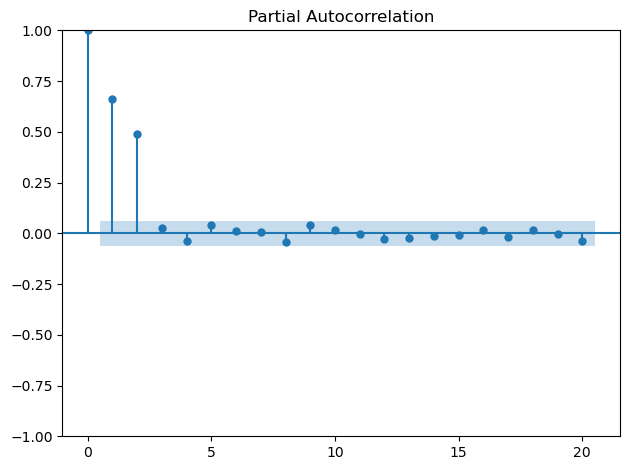

In [74]:
plot_pacf(AR2_process, lags=20)
plt.tight_layout()

**INTERIM CONCLUSION**

The coefficients in the PACF plot will be significant up until lag p. Afterward, they should not be significantly different from 0.

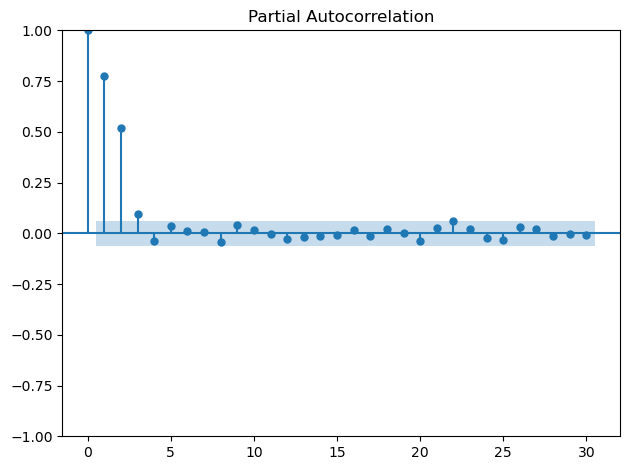

In [75]:
plot_pacf(foot_traffic_diff)
plt.tight_layout()

**INTERIM CONCLUSION**

there are no significant coefficients after lag 3. Therefore, the differenced average weekly foot traffic is an autoregressive process of
order 3, which can also be denoted as AR(3).

### 3. Forcast AR

In [76]:
diff_df= pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})
train_df= diff_df[:-52] # keep all except last 52 weeks of data
test_df= diff_df[-52:] # keep only last 52 weeks
print(len(train_df))
print(len(test_df))

# Note that the sum of both sets gives 999, which is one less
#   data point than our original series. This is normal, since we applied differencing to
#   $make the series stationary

947
52


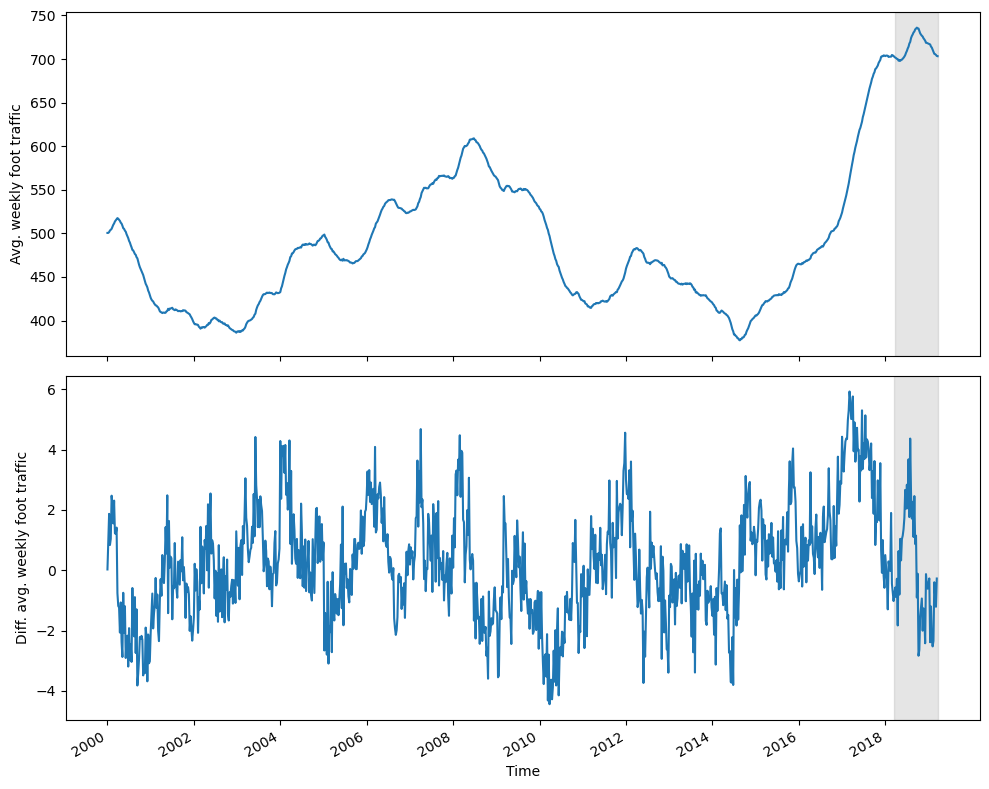

In [77]:
# Visualise testing period of 52 weeks

fig, (ax1, ax2)= plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(len(df) - 52, len(df) , color='#808080', alpha=.2)

ax2.plot(diff_df['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(len(diff_df)-52, len(diff_df), color='#808080', alpha=.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [78]:
def rolling_forecast(
    df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str
) -> list:
    """
    Perform a rolling forecast over a time series using specified methods: mean, last value, or AR (Auto-Regressive).

    Parameters:
    ----------
    df : pd.DataFrame
        A DataFrame containing the time series data, with rows as observations.
    train_len : int
        The length of the initial training data used to calculate predictions.
    horizon : int
        The number of steps ahead for the forecasting horizon.
    window : int
        The window size for recalculating predictions iteratively.
    method : str
        The forecasting method to use. Options:
        - 'mean': Predicts the mean of the observed data up to the current point.
        - 'last': Predicts the last observed value as the forecast.
        - 'AR': Uses an Auto-Regressive (AR) model (via SARIMAX) to make predictions.

    Returns:
    -------
    list
        A list of forecasted values for the specified horizon.

    Methods:
    -------
    1. 'mean': For each rolling window, computes the mean of all observations up to the current point and repeats it for the window length.
    2. 'last': For each rolling window, predicts the last observed value and repeats it for the window length.
    3. 'AR': Fits an AR(3) model to the data observed so far and generates predictions for the next `window` steps.
    
    Notes:
    -----
    - Ensure the DataFrame `df` is structured such that the target variable is accessible.
    - The SARIMAX-based AR model requires the `statsmodels` library.
    - Use `window` <= `horizon` to maintain validity of predictions.

    Example:
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> from statsmodels.tsa.statespace.sarimax import SARIMAX

    >>> df = pd.DataFrame(np.random.randn(100), columns=["value"])
    >>> rolling_forecast(df, train_len=50, horizon=20, window=5, method='mean')
    [ ... list of predictions ... ]
    """
    
    # The total length includes the initial training data plus the forecast horizon
    total_len = train_len + horizon

    # `end_idx` represents the endpoint for training data. This will be updated for AR-based methods.
    end_idx = train_len

    # Check which forecasting method is chosen
    if method == 'mean':
        pred_mean = []  # Initialize an empty list to store predictions for the 'mean' method

        # Loop over forecast windows
        for i in range(train_len, total_len, window):
            # Calculate the mean of all values up to the current index (training window)
            mean = np.mean(df[:i].values)

            # Extend the predictions by repeating the mean for the next 'window' steps
            pred_mean.extend(mean for _ in range(window))
            
        # Return the combined list of predictions
        return pred_mean

    elif method == 'last':
        pred_last_value = []  # Initialize an empty list to store predictions for the 'last value' method

        # Loop over forecast windows
        for i in range(train_len, total_len, window):
            # Select the last observed value from the current training window
            last_value = df[:i].iloc[-1].values[0]

            # Extend the predictions by repeating the last observed value for the next 'window' steps
            pred_last_value.extend(last_value for _ in range(window))

        # Return the combined list of predictions
        return pred_last_value

    elif method == 'AR':
        pred_AR = []  # Initialize an empty list to store predictions for the 'AR' method
        
        # Loop over forecast windows
        for i in range(train_len, total_len, window):
            # Create an Auto-Regressive (AR) model using SARIMAX with the training data
            model = SARIMAX(df[:i], order=(3, 0, 0))  # AR(3) with no differencing or moving average
            
            # Fit the AR model to the training data
            res = model.fit(disp=False)
            
            # Generate predictions for the next 'window' steps
            predictions = res.get_prediction(0, i + window - 1)
            
            # Extract only the predictions corresponding to the forecast window
            oos_pred = predictions.predicted_mean.iloc[-window:]
            
            # Extend the predictions list with the forecast values
            pred_AR.extend(oos_pred)

        # Return the combined list of predictions
        return pred_AR

In [79]:
TRAIN_LEN= len(train_df)
HORIZON= len(test_df)
WINDOW= 1

pred_mean= rolling_forecast(diff_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value= rolling_forecast(diff_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR= rolling_forecast(diff_df, TRAIN_LEN, HORIZON, WINDOW,'AR')

test_df['pred_mean']= pred_mean
test_df['pred_last_value']= pred_last_value
test_df['pred_AR']= pred_AR

test_df.head()

/tmp/ipykernel_1507/4118977068.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_mean']= pred_mean
/tmp/ipykernel_1507/4118977068.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_last_value']= pred_last_value
/tmp/ipykernel_1507/4118977068.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


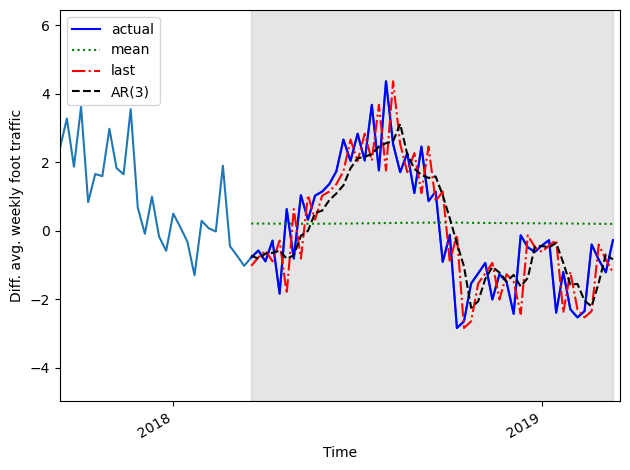

In [80]:
fig, ax= plt.subplots()

ax.plot(diff_df['foot_traffic_diff'])
ax.plot(test_df['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test_df['pred_mean'], 'g:', label='mean')
ax.plot(test_df['pred_last_value'], 'r-.', label='last')
ax.plot(test_df['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947,998, color='#808080', alpha=.2)
ax.set_xlim(920,999)

plt.xticks([936,988],[2018,2019])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### 4. Measure Model Performance

In [81]:
mse_mean= mean_squared_error(test_df['foot_traffic_diff'], test_df['pred_mean'])
mse_last= mean_squared_error(test_df['foot_traffic_diff'], test_df['pred_last_value'])
mse_AR= mean_squared_error(test_df['foot_traffic_diff'], test_df['pred_AR'])

print(f'MSE mean={mse_mean:.2f}')
print(f'MSE last={mse_last:.2f}')
print(f'MSE AR(3)={mse_AR:.2f}')

MSE mean=3.11
MSE last=1.45
MSE AR(3)=0.92


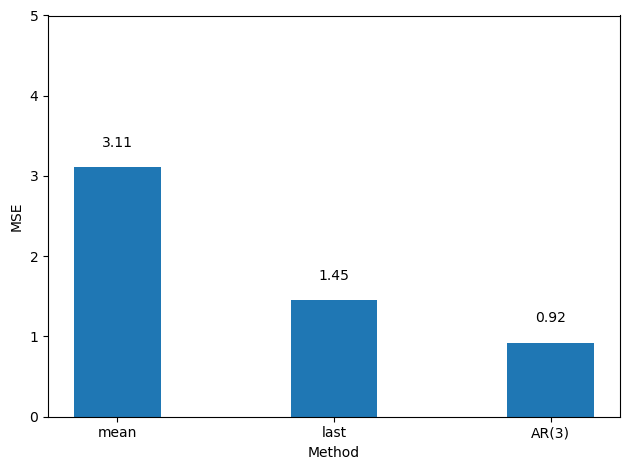

In [82]:
fig, ax= plt.subplots()

x= ['mean', 'last', 'AR(3)']
y= [mse_mean, mse_last, mse_AR]

ax.bar(x,y, width=.4)
ax.set_xlabel('Method')
ax.set_ylabel('MSE')
ax.set_ylim(0,5)

for i, v in enumerate(y):
    plt.text(x=i, y=v+.25, s=str(round(v,2)), ha='center')

plt.tight_layout()

**INTERIM CONCLUSION**

The MSE for the AR(3) model is the lowest of the three, we conclude that the AR(3) model is the best-performing method

### 5. Inverse Transform

our forecasts are differenced values after transformation applied, so we need to reverse the transformation
in order to bring our forecasts back to the original scale of the data; otherwise, our predictions
will not make sense in a business context.

In [83]:
df['pred_foot_traffic']= pd.Series()
df['pred_foot_traffic'][948:]= df['foot_traffic'].iloc[948] + test_df['pred_AR'].cumsum()

/tmp/ipykernel_1507/824772160.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_foot_traffic'][948:]= df['foot_traffic'].iloc[948] + test_df['pred_AR'].cumsum()
/tmp/ipykernel_1507/824772160.py:2: SettingWithCopyWarning: 
A value 

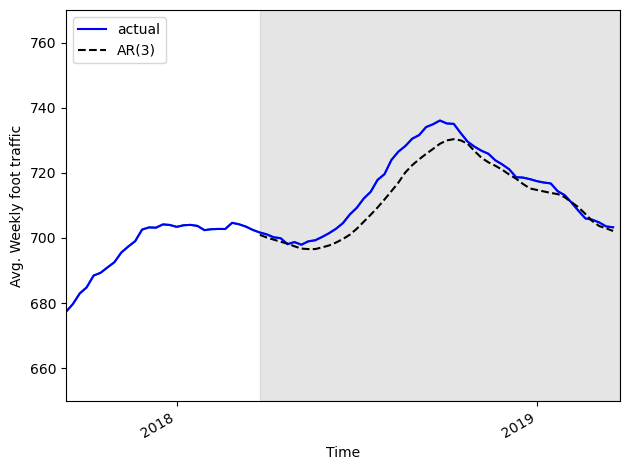

In [84]:
fig, ax= plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Avg. Weekly foot traffic')
ax.axvspan(948, 1000, color='#808080', alpha=.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650,770)

plt.xticks([936, 988], [2018,2019])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### 6. Report Errors

In [85]:
mae_AR= mean_absolute_error(df['foot_traffic'][948:],df['pred_foot_traffic'][948:])
print(f'MAE AR(3)={mae_AR:.2f}')

MAE AR(3)=3.48


**INTERIM CONCLUSION**

A mean absolute error of 3.45. This means that our predictions are off
by 3.45 people on average, either above or below the actual value for the week’s foot
traffic. Note that we report the MAE because it has a simple business meaning that is
easy to understand and interpret.

## CH6 Modeling complex time series

### ARMA(p,q)

The autoregressive moving average process is a combination of the autoregressive process
and the moving average process. It states that the present value is linearly dependent
on its own previous values and a constant, just like in an autoregressive process, as well
as on the mean of the series, the current error term, and past error terms, like in a
moving average process.

It is denoted as ARMA(p,q), where p is the order of the autoregressive process, and
q is the order of the moving average process. The general equation of the ARMA(p,q)
model is
`yt = C + φ1yt–1 + φ2yt–2 +⋅⋅⋅+ φp * yt–p + μ + ϵt + θ1ϵt–1 + θ2ϵt–2 +⋅⋅⋅+ θqϵt–q`
An ARMA(0,q) process is equivalent to an MA(q) process, since the order p = 0 cancels
the AR(p) portion. An ARMA(p,0) process is equivalent to an AR(p) process, since
the order q = 0 cancels the MA(q) portion.

the order p determines the number of past values that affect the present value.
Similarly, the order q determines the number of past error terms that affect the present
value. In other words, the orders p and q dictate the number of parameters for the
autoregressive and moving average portions, respectively.

**The ARMA(p,q) model requires the series to be stationary before fitting an ARMA(p,q) model**

#### General Modeling Procedure

<img src="./images/ARMA-1.png" width="350" />

<img src="./images/ar-1.png" width="350" />

### simulate an ARMA(1,1)

yt = 0.33yt –1 + 0.9ϵt –1 + ϵt

#### Load Data (Generate ARMA process)

In [86]:
np.random.seed(42)

ar1=np.array([1, -0.33])
ma1=np.array([1, .9])

arma_1_1= ArmaProcess(ar1,ma1).generate_sample(nsample=1000)

#### 1. Verify Stationary

In [87]:
ADF_result= adfuller(arma_1_1)

print(f'ADF Stat: {ADF_result[0]}')
print(f'p-val: {ADF_result[1]}')

ADF Stat: -6.429878682042696
p-val: 1.707846668009654e-08


**INTERIM CONCLUSION**

Since we have a large
negative ADF statistic and a p-value that’s much smaller than 0.05, we can conclude
that our simulated ARMA(1,1) process is stationary.

#### 2. Check for AR process

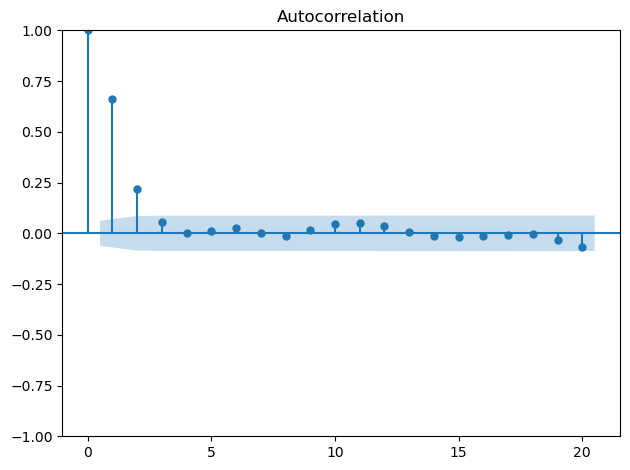

In [88]:
plot_acf(arma_1_1, lags=20)
plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

the
sinusoidal pattern on the plot, meaning that an AR(p) process is in play.
Also, the last significant coefficient is at lag 2, which suggests that q = 2.
However, we know that we simulated an ARMA(1,1) process, so q must be
equal to 1! Therefore, the ACF plot cannot be used to infer the order q of
an ARMA(p,q) process.

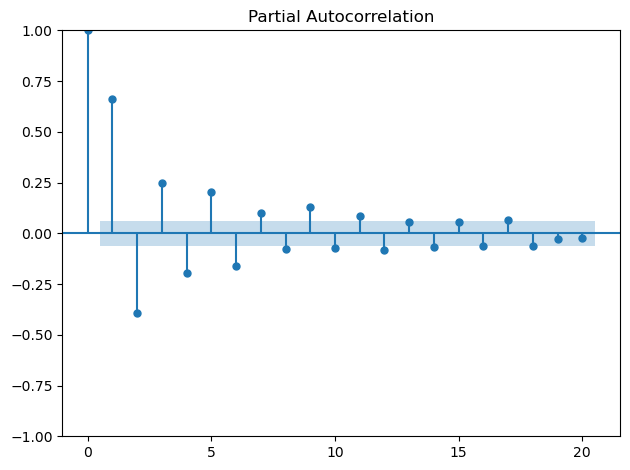

In [89]:
plot_pacf(arma_1_1, lags=20)
plt.tight_layout()
plt.show()

**INTERIM CONCLUSION**

sinusoidal pattern with no clear cutoff between significant and non-significant
coefficients. From this plot, we cannot infer that p = 1 in our simulated
ARMA(1,1) process, meaning that we cannot determine the order p of an
ARMA(p,q) process using a PACF plot.

If  process is stationary and both the ACF and PACF plots show a decaying or sinusoidal
pattern, then it is a stationary ARMA(p,q) process.

#### 3. Devising a general modeling procedure

Akaike information criterion (AIC)
The Akaike information criterion (AIC) is a measure of the quality of a model in relation
to other models. It is used for model selection.
The AIC is a function of the number of parameters k in a model and the maximum
value of the likelihood function : $\hat{L}= 2k -2ln(\hat{L})$
The lower the value of the AIC, the better the model. Selecting according to the AIC
allows us to keep a balance between the complexity of a model and its goodness of
fit to the data.

Remember that the lower the AIC, the better the model relative to other models

#### 4. Find AIC

In [90]:
ps= range(0,4,1)
qs= range(0,4,1)
order_list= list(product(ps,qs))

In [128]:
def optimize_ARMA(endog: Union[pd.Series, List], order_list: List) -> pd.DataFrame:
    """
    The function takes the data and the list of unique (p,q) combinations as input. 
    Inside the function, we initialize an empty list to store each (p,q) combination and its corresponding AIC. 
    Then we iterate over each (p,q) combination and fit an ARMA(p,q) model on our data. We compute
    the AIC and store the result. Then we create a DataFrame and sort it by AIC value in
    ascending order, since the lower the AIC, the better the model. Our function finally
    outputs the ordered DataFrame so we can select the appropriate model.
    """
    results= []
    # Iterate over each unique (p,q) combinations
    #for order in tqdm.notebook.tqdm(order_list):
    for order in tqdm(order_list, desc="Optimizing ARMA"):
        try:
            # Fit an ARMA(p,q) model using the SARIMAX function. We specify simple_differencing=False to prevent differencing. 
            # Recall that differencing is the result of yt – yt–1. We also specify disp=False to avoid printing convergence messages to the console.
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)

            # Calculate model AIC
            aic = model.aic

            # Append the (p,q) combination and AIC as a tuple to the result list
            results.append({'(p,q)': order, 'AIC': aic})
        except Exception as e:
            # Log the error for debugging purposes if needed
            print(f"Error for order {order}: {e}")
            continue

    result_df = pd.DataFrame(results)
    
    # Sort in ascending order the lower the AIC is better
    return result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)


In [127]:
result_df= optimize_ARMA(arma_1_1, order_list)
result_df

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Optimizing ARMA: 100%|████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.60it/s]


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.981271
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


**INTERIM CONCLUSION**

model with the lowest AIC corresponds to an ARMA(1,1) model, which is exactly the process that we simulated, meaning that we successfully identified the order of our simulated data.

#### 5. Residual Analysis

The residuals of a model are simply the difference between the predicted values
and the actual values.

#### 5.1 QUALITATIVE ANALYSIS: STUDYING THE Q-Q PLOT

The Q-Q plot is constructed by plotting the quantiles of our residuals on the y-axis
against the quantiles of a theoretical distribution,

If both distributions are similar, meaning that the distribution of the residuals is
close to a normal distribution, the Q-Q plot will display a straight line that approximately
lies on y = x. This in turn means that our model is a good fit for our data.

#### 5.2 QUANTITATIVE ANALYSIS: APPLYING THE LJUNG-BOX TEST

Ljung-Box test
The Ljung-Box test is a statistical test that determines whether the autocorrelation of
a group of data is significantly different from 0.
In time series forecasting, we apply the Ljung-Box test on the model’s residuals to
test whether they are similar to white noise. The null hypothesis states that the data
is independently distributed, meaning that there is no autocorrelation. If the p-value
is larger than 0.05, we cannot reject the null hypothesis, meaning that the residuals
are independently distributed. Therefore, there is no autocorrelation, the residuals
are similar to white noise, and the model can be used for forecasting.

#### 5-3 Perform Resid analisys

In [92]:
model= SARIMAX(arma_1_1, order=(1,0,1), simple_differencing=False)
model_fit= model.fit(disp=False)
residuals= model_fit.resid

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

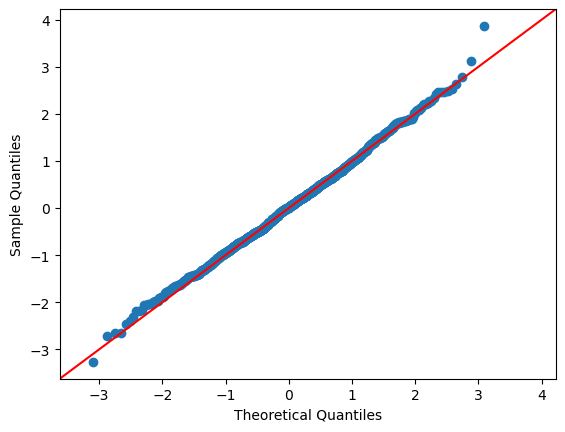

In [93]:
qqplot(residuals, line='45')
plt.tight_layout

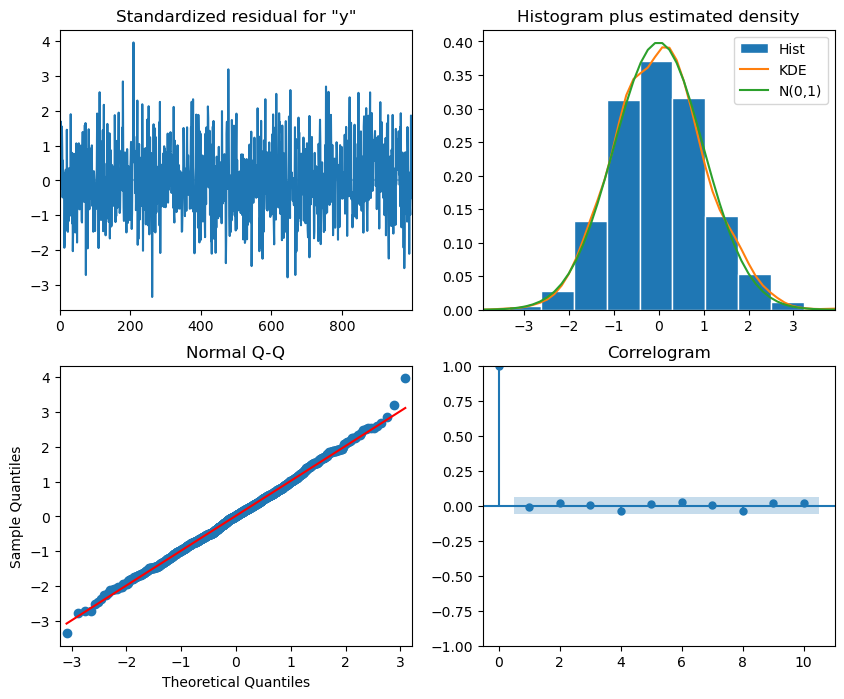

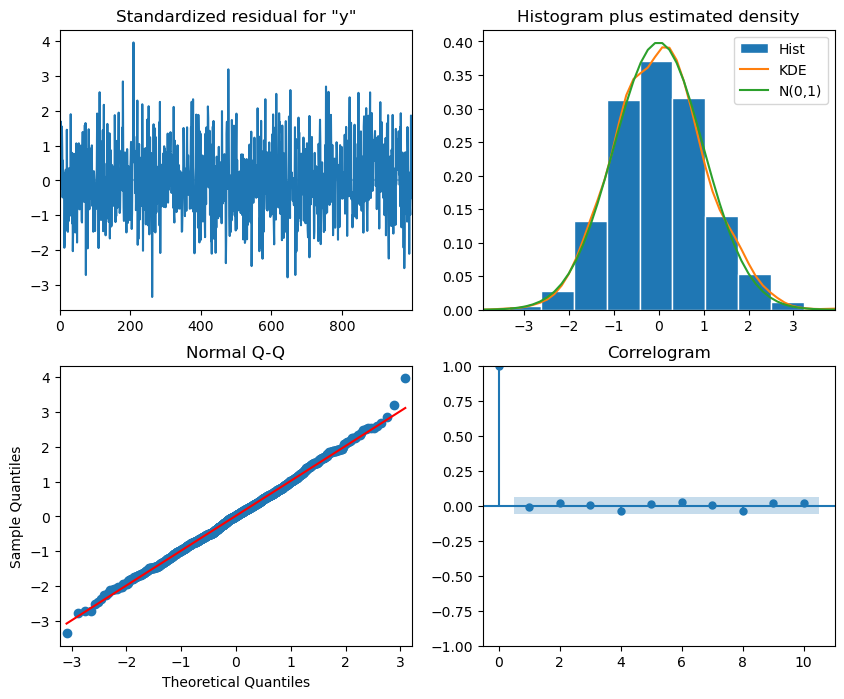

In [94]:
model_fit.plot_diagnostics(figsize=(10,8))

**INTERIM CONCLUSION**

- top-left plot shows the residuals across the entire dataset. You can see that
there is no trend, and the mean seems stable over time, which is indicative of stationarity,
just like white noise.
- top-right plot shows a histogram of the residuals. You can see the shape of a
normal distribution on this plot, which again indicates that the residuals are close to
white noise, as white noise is normally distributed as well.
- bottom-left is Q-Q plot
- the bottom-right plot shows the autocorrelation function of our residuals. You
can see that there is only a significant peak at lag 0, and no significant coefficients otherwise.
This means that the residuals are not correlated, which further supports the conclusion
that they are similar to white noise, which is what we expect from a good model.

In [136]:
lbvalue= acorr_ljungbox(residuals, np.arange(1, 11, 1))

lbvalue

,lb_stat,lb_pvalue
1,0.042190,0.837257
2,0.418364,0.811247
3,0.520271,0.914416
4,0.850554,0.931545
5,0.850841,0.973678
6,1.111754,0.981019
7,2.124864,0.952607
8,3.230558,0.919067
9,3.248662,0.953615
10,3.588289,0.964015


**INTERIM CONCLUSION**

The returned p-values all exceed 0.05. Therefore, we can conclude that our residuals
are indeed uncorrelated. Our ARMA(2,2) model has passed all the checks on the
residual analysis, and we are ready to use this model to forecast bandwidth usage.

### Forcast Bandwidth usage

In [102]:
df= pd.read_csv('./datasets/bandwidth.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hourly_bandwidth  10000 non-null  float64
dtypes: float64(1)
memory usage: 78.3 KB


In [100]:
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


#### Visualize dataset

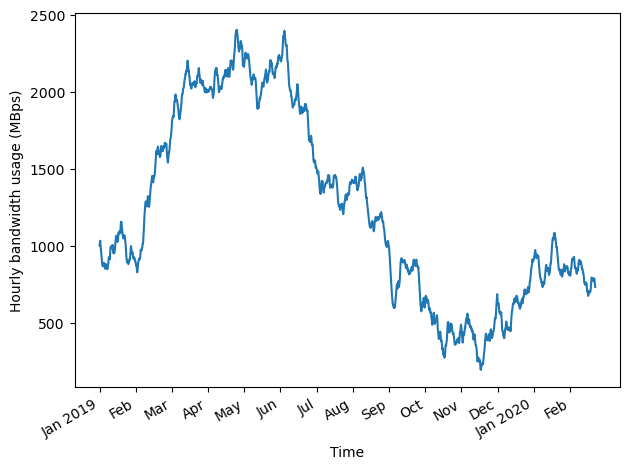

In [103]:
fig, ax= plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [104]:
ADF_result= adfuller(df['hourly_bandwidth'])

print(f'ADF stat:{ADF_result[0]} p-val:{ADF_result[1]}')

ADF stat:-0.8714653199452762 p-val:0.7972240255014542


#### Transform

In [105]:
# For remove effect of the trend and stabilize the mean of the series we wil use differenciating

band_diff= np.diff(df['hourly_bandwidth'],n=1)

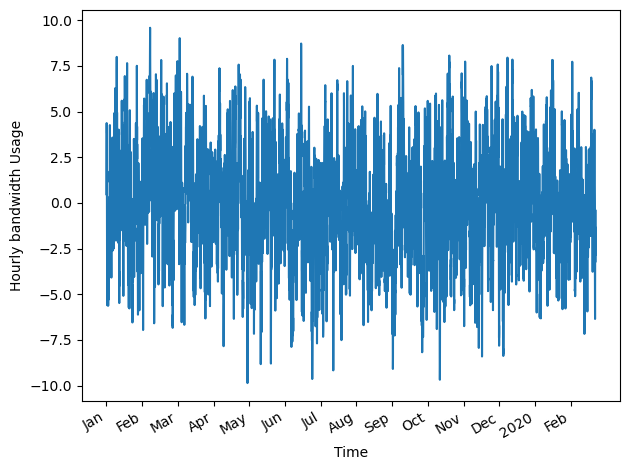

In [107]:
fig, ax= plt.subplots()

ax.plot(band_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth Usage')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])


fig.autofmt_xdate()
plt.tight_layout()

In [109]:
ADF_result= adfuller(band_diff)

print(f'ADS stat: {ADF_result[0]}, p-val:{ADF_result[1]}')

ADS stat: -20.694853863789017, p-val:0.0


**INTERIM CONCLUSION**
The p-val is lesser than 0.05 thus we can reject H0 and conclude that series is now stationary


#### Train-Test Split

In [119]:
df_diff = pd.DataFrame({'bandwidth_diff': band_diff})

train= df_diff[:-168]

# There are 168 hrs in a week, so we will assign last 168 data points to the test set
test= df_diff[-168:]

In [121]:
print(f'df.shape={df.shape}')
print(f'df_diff.shape={df_diff.shape}')
print(f'test.shape={test.shape}')
print(f'train.shape={train.shape}')

df.shape=(10000, 1)
df_diff.shape=(9999, 1)
test.shape=(168, 1)
train.shape=(9831, 1)


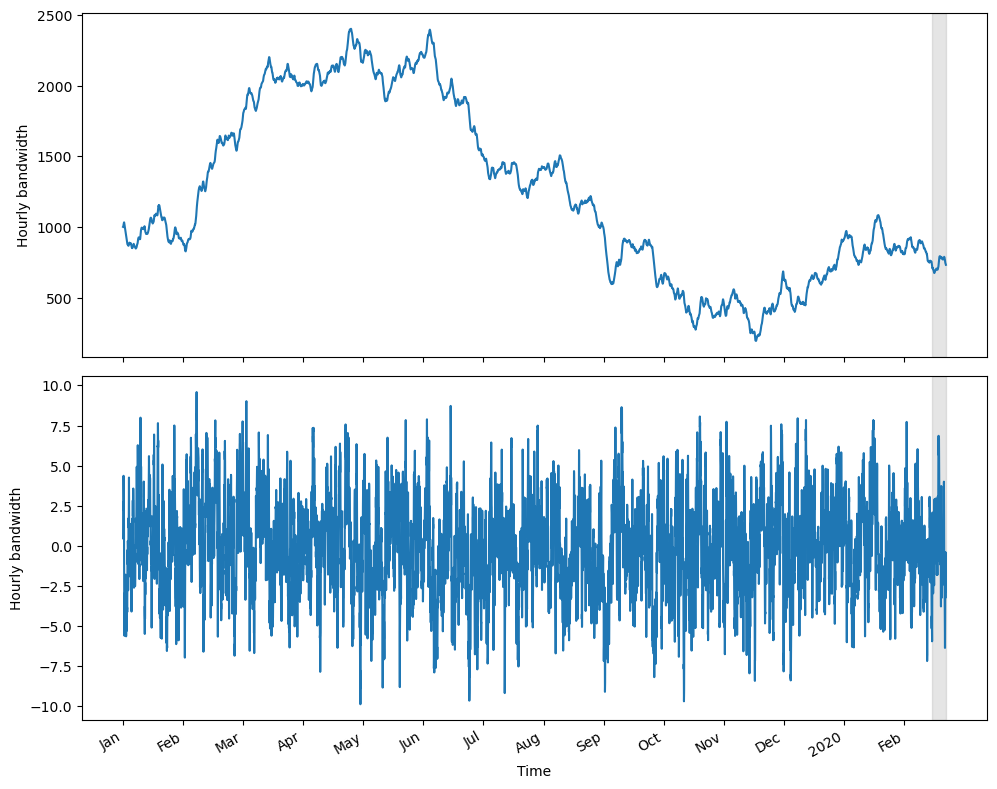

In [125]:
# Visualize test and train

fig, (ax1,ax2)= plt.subplots(nrows=2, ncols=1,sharex=True,figsize=(10,8))
ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth')
ax1.axvspan(train.shape[0],df.shape[0], color='#808080', alpha=.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth')
ax2.axvspan(train.shape[0], band_diff.shape[0], color="#808080", alpha=.2)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()


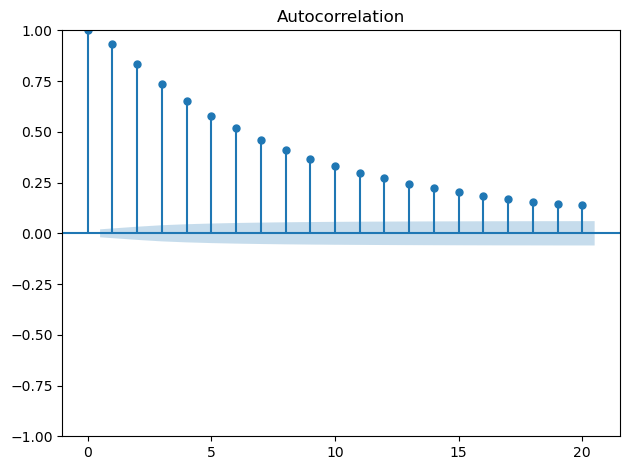

In [110]:
plot_acf(band_diff, lags=20)
plt.tight_layout()

**INTERIM CONCLUSION**

The process is not a random walk as we are observing a significant autocorelation coefs after lag 0. Also we see that coefs are decaying exponentialy as the lag increases.
Also we may conclude that the process is AR as there is no lag at which coefs abruptly become non significant, thus we should check pacf to check if there a partial AR



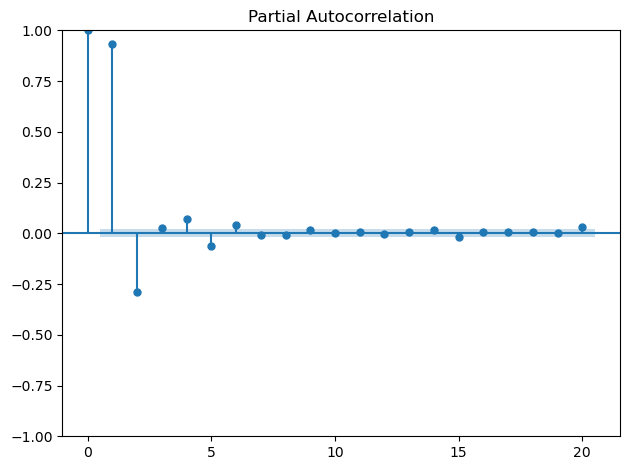

In [111]:
plot_pacf(band_diff, lags=20)
plt.tight_layout()

#### Find optimal (p,q)

In [129]:
# Set order p, that can have the values {0,1,2,3}
p= range(0,4,1)

# Set order q, that can have the values {0,1,2,3}
q= range(0,4,1)

# Generate unique (p,q) combinations
order_list= list(product(p,q))

result_df= optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Optimizing ARMA: 100%|████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.39it/s]


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


**INTERIM CONCLUSION**

We can see that top most 3 values are not significantly differs one from each others, howere 2,2 seems to be most applicable due to the following reasons:
- Less complex
- q=2, confirms by pacf plot above

#### Resid analysis

In [131]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit= model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Thu, 09 Jan 2025   AIC                          27991.604
Time:                        14:12:47   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

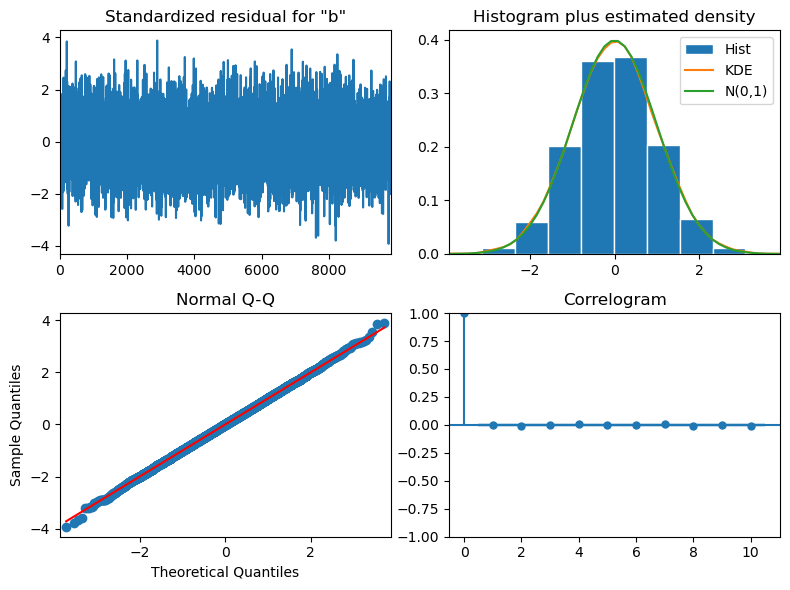

In [141]:
model_fit.plot_diagnostics(figsize=(8,6))
plt.tight_layout()

In [140]:
residuals= model_fit.resid
lbvalue= acorr_ljungbox(residuals, np.arange(1,11,1))
print(list(lbvalue['lb_pvalue']))

[0.8372573208392933, 0.8112474180864726, 0.9144159602182859, 0.9315448954478323, 0.9736778722318123, 0.9810190538795917, 0.9526071353331356, 0.919066608745711, 0.953615041477017, 0.9640151782785467]


**INTERIM CONCLUSION**

- Resid plot(top-left): shows no trend, and mean seems constant over time - meaining residuals are stationary
- Density plot (top-right): shape similat to normal distributions
- Q-Q: show normal stright line close to y=x
- ACF (bottom right): show no autocorelation after lag 0

Thus our plot diagnostics demostrates that residuals are resemble white noise since they are normaly distributed and uncorelated

The ljung-box test returned p-values exceeded 0.05 thus we can not reject h0, which means that our resids are not corelated and independetly distributed like white noise.
Thus our ARMA(2,2) mode has passed all the checks ont the resid analysis

P.S.

This analysis is both 
- qualitative, because we can study the Q-Q plot to evaluate whether the residuals are normally distributed, as well as
- quantitative, since we can apply the Ljung-Box test to determine whether the residuals are correlated or not

#### Forcasting

In [147]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len= train_len + horizon
    end_idx= train_len

    # Sliding window mean
    if method == 'mean':
        pred_mean=[]

        for i in range(train_len, total_len, window):
            mean= np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    # Last know value in current window
    if method == 'last':
        pred_last_value= []

        for i in range(train_len, total_len, window):
            last_value= df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA= []

        for i in range(train_len, total_len, window):
            model= SARIMAX(df[:i], order=(2,0,2))
            res= model.fit(disp=False)
            predictions= res.get_prediction(0, i+ window -1)
            oos_pred= predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA
        

In [152]:
%%time
# Evaluate the performancew if the different forecasting methods. We will predict 2 steps at a time because we have ARMA(2,2)
# we can't predict beyond q-steps into the future with MA(q) as it simply return the mean, so the predictions will remain flat

pred_df= test.copy()
TRAIN_LEN= len(train)
HORIZON= len(test)
WINDOW= 2

pred_mean= rolling_forecast(df_diff, TRAIN_LEN, HORIZON,WINDOW,'mean')
pred_last_val= rolling_forecast(df_diff, TRAIN_LEN, HORIZON,WINDOW,'last')
pred_ARMA= rolling_forecast(df_diff, TRAIN_LEN, HORIZON,WINDOW,'ARMA')

test.loc[:,'pred_mean']= pred_mean
test.loc[:,'pred_last_val']= pred_last_val
test.loc[:,'pred_ARMA']= pred_ARMA

test.head()

CPU times: user 2min 35s, sys: 10.2 ms, total: 2min 35s
Wall time: 51.4 s


<timed exec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,bandwidth_diff,pred_mean,pred_last_val,ARMA,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596,-0.375596


#### Visualuze

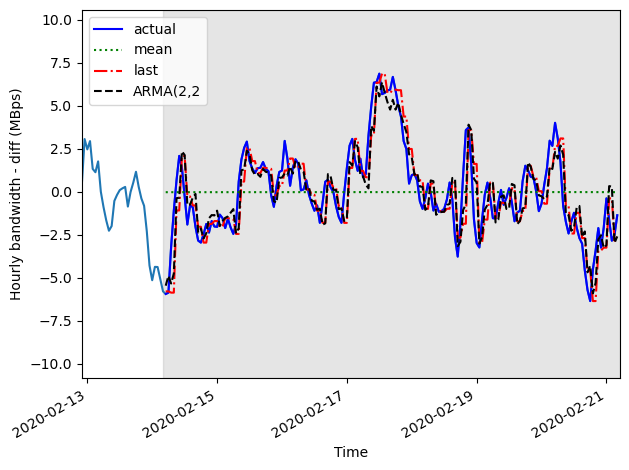

In [154]:
fig, ax= plt.subplots()

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_val'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=.2)

ax.set_xlim(9800,9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

**INTERIM CONCLUSION**

We can see that our ARMA(2,2) is most precise prediction among other methods. Let's confirm that with MSE

In [159]:
mse_mean= mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last= mean_squared_error(test['bandwidth_diff'], test['pred_last_val'])
mse_ARMA= mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(f'MSE(mean): {mse_mean:.2f}')
print(f'MSE(last): {mse_last:.2f}')
print(f'MSE(ARMA): {mse_ARMA:.2f}')

MSE(mean): 6.31
MSE(last): 2.23
MSE(ARMA): 1.77


**INTERIM CONCLUSION**

Our baseline - mean: 6.31, last val: 2.23 and ARMA(2,2): 1.77 which allows us to conclude that we have a well performed winner which is outperforms our benchmarks

#### Reverse transformation

in order to return predictions to original scale

In [161]:
df['pred_bandwidth']= pd.Series()

# to reverse the differencing transformation we apply a cumulative sum
df['pred_bandwidth'][9832:]= df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

/tmp/ipykernel_1507/139550872.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_bandwidth'][9832:]= df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()
/tmp/ipykernel_1507/139550872.py:2: SettingWithCopyWarning: 
A valu

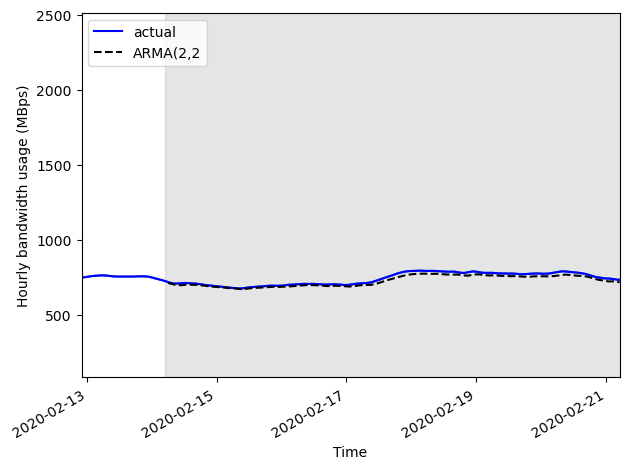

In [163]:
fig, ax= plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=.2)

# zooming in
ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [164]:
mae_ARMA_undiff= mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(f'MAE(ARMA undiff): {mae_ARMA_undiff:.2f}')

MAE(ARMA undiff): 14.00


**INTERIM CONCLUSION**

MAE=14, meainng that our forecast are 14 Mbps above or below actual bandwidth usage

# NON-STATIONARY TIME SERIES

non-stationary time series, meaning that the series has a trend, or its variance is not constant over time

## CH7 Forecasting Non-Stat time series

### ARIMA

An autoregressive integrated moving average (ARIMA) process is the combination of the AR(p) and MA(q) processes, but in terms of the differenced series.

An AutoRegressive Integrated Moving Average process is the combination of:
- AR(p): an autoregressive process
    - (p)determines how many lagged values of the series are included in the model
      
- I(d): an integration
    - (d) defined as the order of integration. Integration is simply the reverse of differencing. The order of integration is thus equal to the number of times a series has been differenced to become stationary.

- MA(q) moving average process.
    - (q) determines how many lagged error terms are included in the model. 

the ARIMA process states that the present value is
dependent on past values coming from the AR(p) portion, and past errors, coming
from the MA(q) portion

**Integrated series** - A time series that can be rendered stationary by applying differencing

the ARIMA(p,d,q) model can be used on non-stationary series, but we must find the order of integration d, which corresponds to the minimum number of times a series must be differenced to become stationary.

#### General Modeling Procedure

<img src="./images/ARIMA-GMP.png" width="450" />

### Load Data

In [248]:
df= pd.read_csv('./datasets/jj.csv')

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


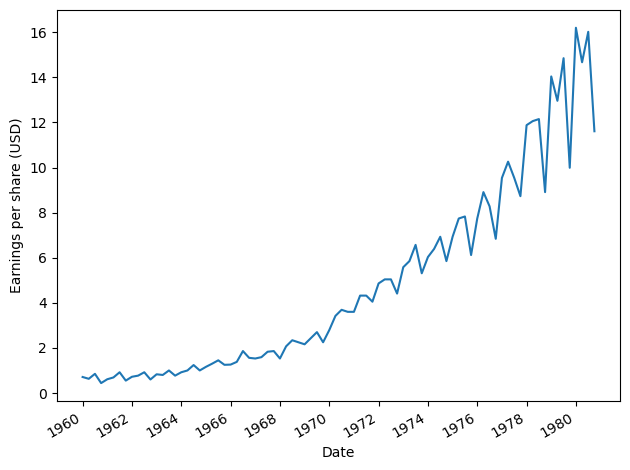

In [250]:
fig, ax= plt.subplots()

ax.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

###  Verify Stationarity

In [251]:
ad_fuller_res= adfuller(df['data'])

print(f'ADF stat: {ad_fuller_res[0]:.2f}')
print(f'p-val: {ad_fuller_res[1]}')

ADF stat: 2.74
p-val: 1.0


**INTERIM CONCLUSION**

ADF stat is not large negative val and p-val > 0.05 thus we can't reject h0, meaning series is non-stat

### Search d

In [252]:
d=0

In [253]:
eps_diff= np.diff(df['data'], n=(d:=d+1))

ad_fuller_res= adfuller(eps_diff)

print(f'd: {d}')
print(f'ADF stat: {ad_fuller_res[0]:.2f}')
print(f'p-val: {ad_fuller_res[1]:.2f}')

d: 1
ADF stat: -0.41
p-val: 0.91


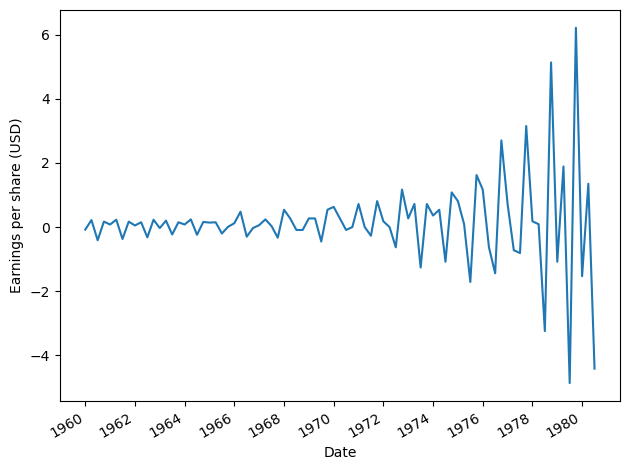

In [254]:
fig, ax= plt.subplots()

ax.plot(df['date'][1:], eps_diff,)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

**INTERIM CONCLUSION**

ADF stat stil not meet stationary conditions along with p-val. Let's do another round

In [255]:
eps_diff2= np.diff(eps_diff, n=1)

ad_fuller_res= adfuller(eps_diff2)

print(f'd: {d}')
print(f'ADF stat: {ad_fuller_res[0]:.2f}')
print(f'p-val: {ad_fuller_res[1]:.3f}')

d: 1
ADF stat: -3.59
p-val: 0.006


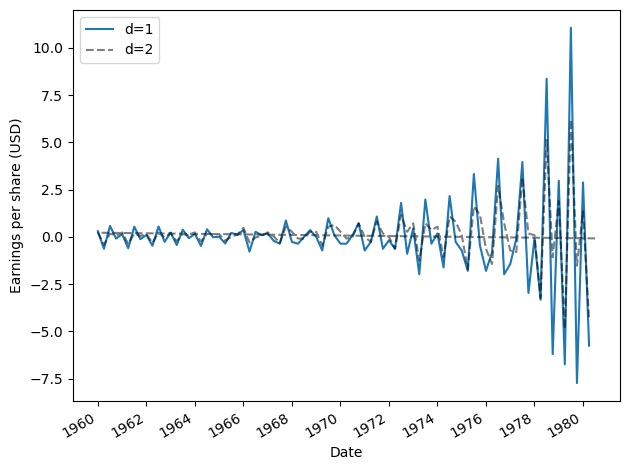

In [256]:
fig, ax= plt.subplots()

ax.plot(df['date'][2:], eps_diff2, label='d=1')
ax.plot(df['date'][1:], eps_diff, 'k--', label='d=2', alpha=.5)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

ax.legend(loc=2)
plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

**INTERIM CONCLUSION**

now we can reject h0, and confirm that our series stationary with d=2

### Train-Test split

We going to forcast with ARIMA model last year. Our dataset have 4 observations per each year(1 point - a quarter)

In [314]:
train=df['data'][:-4]
test=df.iloc[-4:]

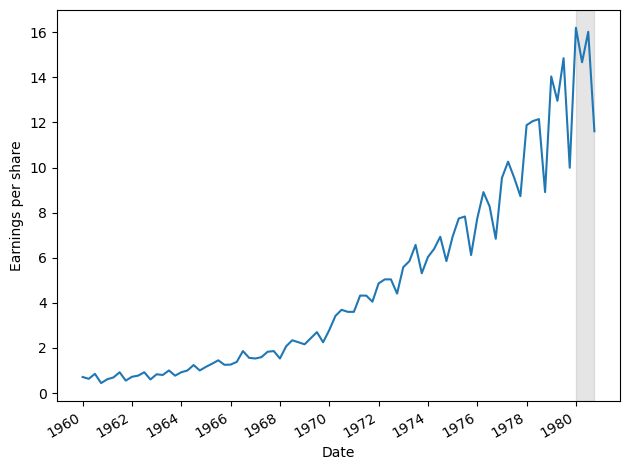

In [258]:
fig, ax= plt.subplots()

ax.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share')

ax.axvspan(80,83,color='#808080', alpha=.2)
plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

### Find AIC (p,d,q)

In [292]:
def optimize_ARIMA1(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results1=[]
    
    for order in tqdm(order_list, desc="Optimizing ARIMA"):
        try:
            model= SARIMAX(endog, order=(order[0],d,order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic= model.aic
        results1.append({'(p,d,q)': (order[0],d,order[1]), 'AIC': round(aic/100,5)})
        
    results_df= pd.DataFrame(results1)

    return results_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

In [293]:
%%time

p= range(0,4,1)
q= range(0,4,1)
d=2

# Generate list of the all unique combinations (p,q)
order_list= list(product(p,q))
order_list

CPU times: user 12 μs, sys: 0 ns, total: 12 μs
Wall time: 15.3 μs


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [294]:
results_df = optimize_ARIMA1(train, order_list, d)
results_df

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invert

,"(p,d,q)",AIC
0,"(3, 2, 3)",1.15268
1,"(3, 2, 1)",1.15625
2,"(3, 2, 2)",1.15672
3,"(3, 2, 0)",1.54431
4,"(0, 2, 3)",1.94655
5,"(0, 2, 2)",2.09275
6,"(2, 2, 3)",2.20667
7,"(1, 2, 3)",2.28268
8,"(1, 2, 2)",2.28936
9,"(2, 2, 2)",2.29975


**INTERIM CONCLUSION**

According to calculations optimal AIC fond for p,d,q=(3,2,3)

### Resid Analysis

In [295]:
model= SARIMAX(train,order=(3,2,3), simple_differencing=False).fit(disp=False)

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [296]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.634
Date:                Fri, 10 Jan 2025   AIC                            115.268
Time:                        16:12:24   BIC                            131.765
Sample:                             0   HQIC                           121.872
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9994      0.037    -27.144      0.000      -1.072      -0.927
ar.L2         -0.9882      0.039    -25.184      0.000      -1.065      -0.911
ar.L3         -0.9760      0.026    -37.946      0.0

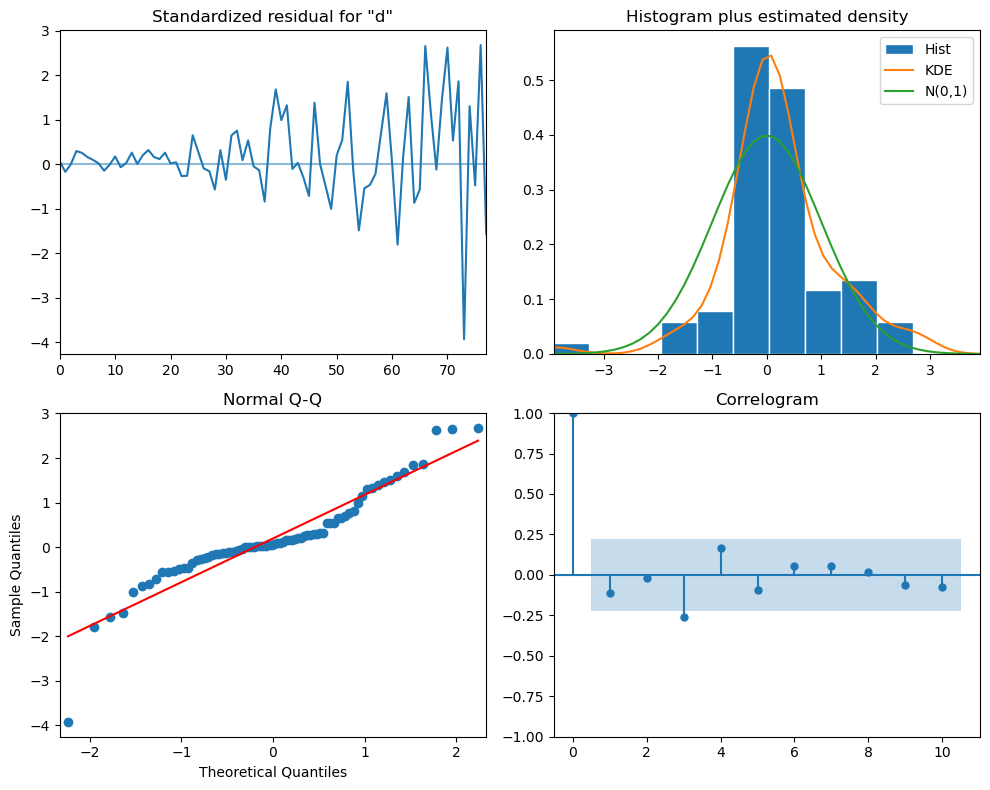

In [298]:
model.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

**INTERIM CONCLUSION**

- top-left plot shows the residuals over time. While there is no trend in
the residuals, the variance does not seem to be constant, which is a discrepancy in
comparison to white noise.
- top right is the distribution of the residuals. We can
see it is fairly close to a normal distribution.
- Q-Q plot leads us to the same conclusion,
as it displays a line that is fairly straight, meaning that the residuals’ distribution
is close to a normal distribution.
- correlogram at the bottom right, we can see that a coefficient seems to be significant at lag 3. However, since it is
not preceded by any significant autocorrelation coefficients

We can assume that this is
due to chance. Therefore, we can say that the correlogram shows no significant coefficients
after lag 0, just like white noise.

In [299]:
residuals= model.resid

# Apply ljung-Box test on the last 10 lags
lbvalue= acorr_ljungbox(residuals, np.arange(1,11,1))

print(list(lbvalue['lb_pvalue']))

[0.2023684048492991, 0.4431909766938158, 0.06360762174445476, 0.056404510773849, 0.08059220945762352, 0.12210007478989934, 0.17147051984007322, 0.24160345134058567, 0.29763132243191937, 0.3475521822799067]


**INTERIM CONCLUSION**

residuals returns a list of p-values that are all larger than 0.05. Therefore, we do not reject the null hypothesis,
and we conclude that the residuals are not correlated, just like white noise.

Our ARIMA(3,2,3) model has passed all the checks, and it can now be used for
forecasting

### Define Baseline Model

In [316]:
# The naive seasonal forecast is implemented by selecting the quarterly EPS 
# reported in 1979 and using the same values as a forecast for the year 1980.

test['naive_seasonal'] = df['data'].iloc[76:80].values

/tmp/ipykernel_1507/1461517710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = df['data'].iloc[76:80].values


### Forecast

In [317]:
# Get the predicted values for the year 1980.
ARIMA_pred= model.get_prediction(80,83).predicted_mean
test['ARIMA_pred']= ARIMA_pred

/tmp/ipykernel_1507/444363041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred']= ARIMA_pred


In [318]:
test.head()

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.860284
81,1980-04-01,14.67,12.96,14.383358
82,1980-07-02,16.02,14.85,16.368720
83,1980-10-01,11.61,9.99,11.680734


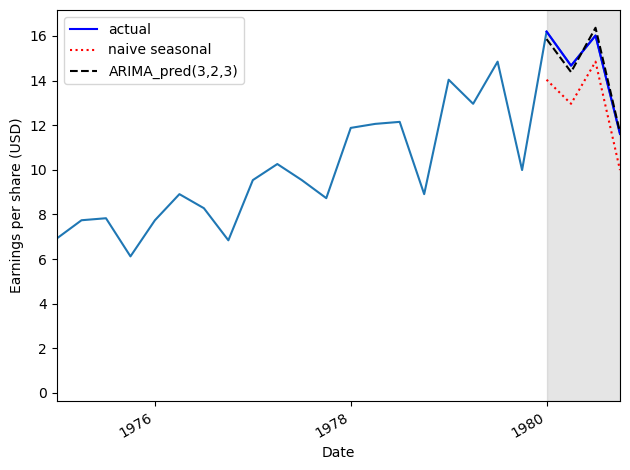

In [323]:
fig, ax= plt.subplots()

ax.plot(df['date'],df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'],'k--', label='ARIMA_pred(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80,83,color="#808080",alpha=.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

In [320]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [324]:
MAPE_naive_seasonal= MAPE(test['data'],test['naive_seasonal'])
MAPE_ARIMA= MAPE(test['data'],test['ARIMA_pred'])

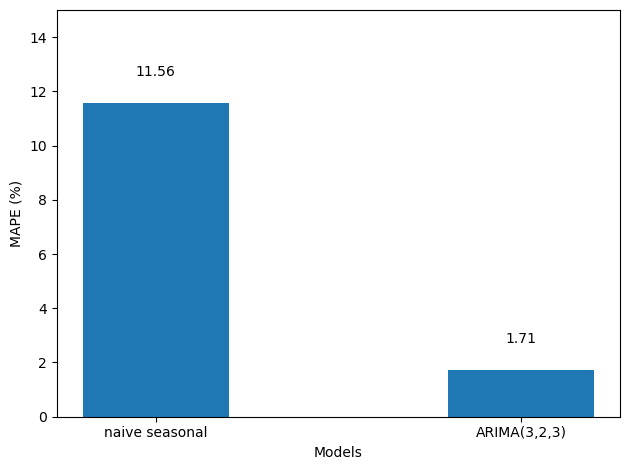

In [327]:
fig, ax=plt.subplots()
x=['naive seasonal', 'ARIMA(3,2,3)']
y=[MAPE_naive_seasonal, MAPE_ARIMA]

ax.bar(x,y,width=.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0,15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

**INTERIM CONCLUSION**

MAPE for the naive seasonal forecast is 11.56%,
while the MAPE for the ARIMA(3,2,3) model is 1.71%, which roughly one fifth of the
benchmark value. This means that our predictions are on average 1.71% off from the
actual values. The ARIMA(3,2,3) model is clearly a better model than the naive seasonal
method.

## CH8 Accounting for Seasonality

### SARIMA

Seasonal AutoRegressive Integrated Moving Average, or $SARIMA(p,d,q)(P,D,Q)_m$

- m stands for the frequency. The frequency is the number of observations per cycle. The length of the cycle depend on the dataset.
  - For data that was recorded every year, quarter, month, or week, the length of a cycle is considered to be 1 year.
  - For data recorded annually,  m = 1 since there is only one observation per year
  - For data recorded quarterly, m = 4 since there are four quarters in a year
  - For data recorded monthly,   m = 12.
  - For weekly data, m = 52
- P is the order of the seasonal AR(P)
- D is the seasonal order of integration,
- Q is the order of the seasonal MA(Q)
process

| Data Collection Frequency | m   |
|---------------------------|-----|
| Annual                   | 1   |
| Quarterly                | 4   |
| Monthly                  | 12  |
| Weekly                   | 52  |

| Data Collection      | Minute | Hour  | Day   | Week    | Year       |
|-----------------------|--------|-------|-------|---------|------------|
| Daily                |        |       | 7     | 365     |            |
| Hourly               |        | 24    | 168   | 8766    |            |
| Every minute         | 60     | 1440  | 10080 | 525960  |            |
| Every second         | 60     | 3600  | 86400 | 604800  | 31557600   |



#### General Modeling Procedure

<img src="./images/SARIMA-GMP.png" width="450" />

### Load Data

In [328]:
df= pd.read_csv('./datasets/air-passengers.csv')

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


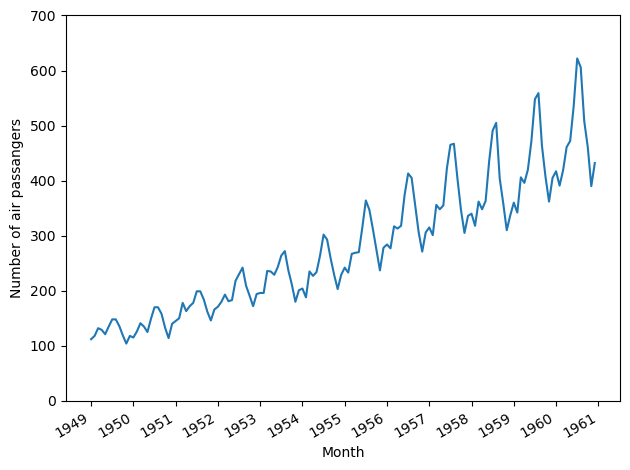

In [331]:
fig, ax= plt.subplots()

ax.plot(df['Month'],df['Passengers'])
ax.set_xlabel('Month')
ax.set_ylabel('Number of air passangers')
ax.set_ylim(0,700)
plt.xticks(np.arange(0,145,12), np.arange(1949,1962,1))

fig.autofmt_xdate()
plt.tight_layout()

### Identify seasonal pattern

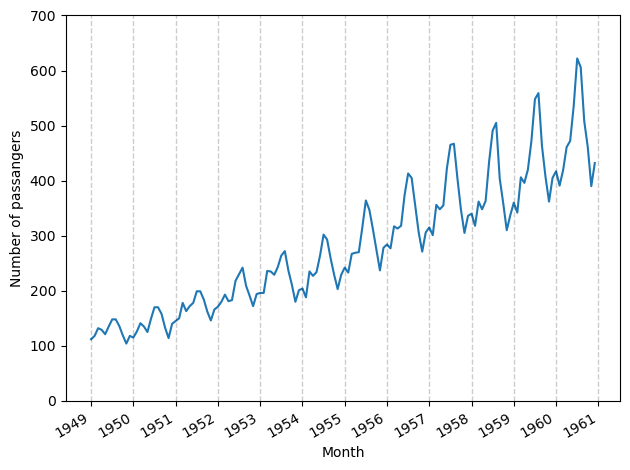

In [334]:
fig, ax= plt.subplots()

ax.plot(df['Month'], df['Passengers'])

for i in np.arange(0,145,12):
    ax.axvline(x=i, linestyle='--', color='k', linewidth=1, alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('Number of passangers')
ax.set_ylim(0,700)
plt.xticks(np.arange(0,145,12), np.arange(1949,1962,1))

fig.autofmt_xdate()
plt.tight_layout()

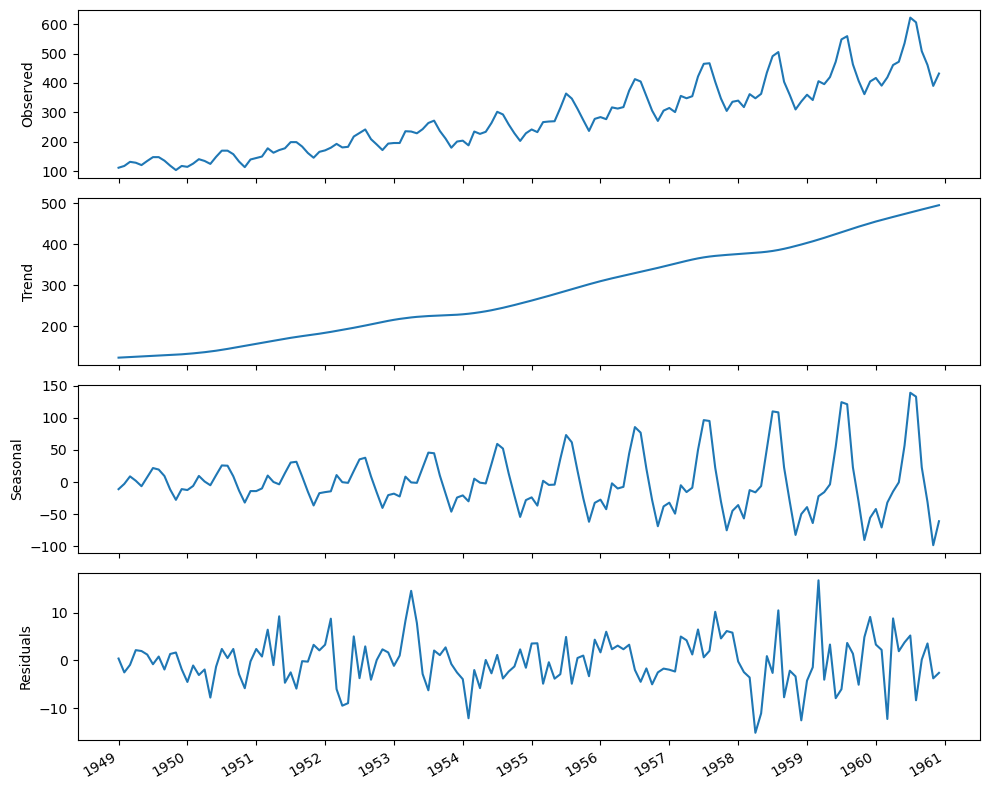

In [339]:
decomposition= STL(df['Passengers'], period=12).fit()

fig, (ax1,ax2,ax3,ax4)= plt.subplots(nrows=4,ncols=1, sharex=True,figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0,145,12), np.arange(1949,1962,1))

fig.autofmt_xdate()
plt.tight_layout()

**INTERIM CONCLUSION**

Each plot shows the magnitude of change that is attributed to that particular component. The sum of the trend, seasonal, and residuals components results in the observed data shown in the top plot.

- observed shows the observed data. 
- trend component, which tells us that the number of air passengers is increasing over time.
- seasonal component, demostrates a repeating pattern through time. In a situation where we have a time series with no seasonal pattern, the decomposition process will display a flat horizontal line at 0 for the seasonal component.
- residuals, are variations in the data that cannot be explained by the trend or the seasonal component.

Thus we can conclude that our series have clear seasonal pattern

### Train-Test split

In [359]:
# for train take all data points but the last twelve, as they will be used for the test set.
train= df['Passengers'][:-12]
test= df.iloc[-12:]

### Func optimize_SARIMA

In [418]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results= []
    
    for order in tqdm(order_list, desc="Optimizing Model"):
        try:
            with warnings.catch_warnings():                
                warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
                warnings.filterwarnings("ignore", message="Non-stationary starting seasonal autoregressive Using zeros as starting parameters.")
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.") 
                warnings.filterwarnings("ignore", message="Non-invertible starting seasonal moving average.")
                warnings.filterwarnings("ignore", message="Non-invertible starting seasonal moving average Using zeros as starting parameters.")
                model= SARIMAX(endog, 
                               order=(order[0],d,order[1]), 
                               seasonal_order=(order[2],D,order[3],s),                            
                               simple_differencing=False).fit(disp=False)
               
        except:
            continue

        aic= model.aic
        results.append(
            {
                '(p,d,q)(P,D,Q)':(order[0],d,order[1],order[2],D,order[3]),
                'AIC':round(aic /100,2)
            }
        )

    results_df= pd.DataFrame(results)

    return results_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

### ARIMA

#### Verify Stationary

In [419]:
ad_fuller_res= adfuller(df['Passengers'])

print(f'ADF stat: {ad_fuller_res[0]:.2f}')
print(f'p-val: {ad_fuller_res[1]:.2f}')

ADF stat: 0.82
p-val: 0.99


In [420]:
df_diff= np.diff(df['Passengers'],n=1)
ad_fuller_res= adfuller(df_diff)

print(f'ADF stat: {ad_fuller_res[0]:.2f}')
print(f'p-val: {ad_fuller_res[1]:.3f}')

ADF stat: -2.83
p-val: 0.054


In [421]:
df_diff2=np.diff(df['Passengers'],n=2)
ad_fuller_res= adfuller(df_diff2)

print(f'ADF stat: {ad_fuller_res[0]:.3f}')
print(f'p-val: {ad_fuller_res[1]:.3f}')

ADF stat: -16.384
p-val: 0.000


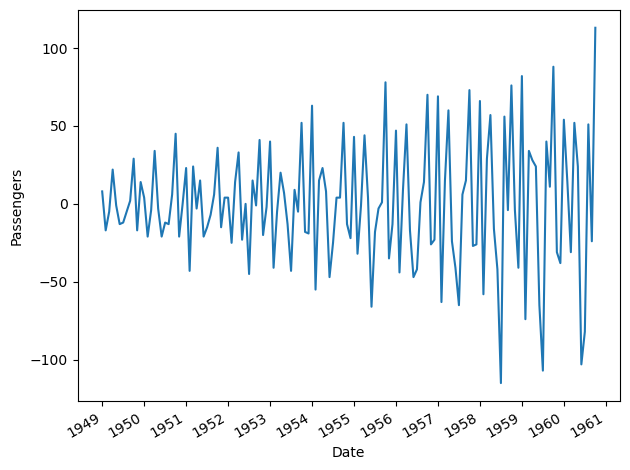

In [422]:
fig, ax=plt.subplots()

ax.plot(df['Month'][2:],df_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.set_xticks(np.arange(0,145,12), np.arange(1949,1962,1))

fig.autofmt_xdate()
plt.tight_layout()

**INTERIM CONCLUSION**

d=2, when h0 could be rejected, meaning series become stationary

#### Search order

In [393]:
# Define a range of possible values for the parameters p and q. Select ramge 
# from 0 to 12 to allow ARIMA model to go back 12 timesteps in time

p= range(0,13,1)
q= range(0,13,1)
P= [0]
Q= [0]
D= 0
s=12

ARIMA_order_list= list(product(p,q,P,Q))

In [396]:
%%time
# ~16 min
ARIMA_result_df= optimize_SARIMA(train, ARIMA_order_list,d,D,s)
ARIMA_result_df

Optimizing Model: 100%|█████████████████████████████████████████████████████| 169/169 [01:31<00:00,  1.84it/s]

CPU times: user 16min 10s, sys: 173 ms, total: 16min 10s
Wall time: 1min 31s


,"(p,d,q)(P,D,Q)",AIC
0,"(11, 2, 3, 0, 0, 0)",10.17
1,"(11, 2, 4, 0, 0, 0)",10.19
2,"(12, 2, 0, 0, 0, 0)",10.20
3,"(11, 2, 5, 0, 0, 0)",10.20
4,"(11, 2, 1, 0, 0, 0)",10.21
...,...,...
164,"(5, 2, 0, 0, 0, 0)",12.82
165,"(3, 2, 0, 0, 0, 0)",13.00
166,"(2, 2, 0, 0, 0, 0)",13.03
167,"(1, 2, 0, 0, 0, 0)",13.08


**INTERIM CONCLUSION**

As
we can see, best ARIMA model params are ((11, 2, 3, 0, 0, 0)). Also allowing the order p to vary from 0 to 12 was beneficial for the model, as
the model with the lowest AIC takes into account the past 11 values of the series, since
p = 11.

#### Resid Analysis

In [397]:
ARIMA_model= SARIMAX(train, order=(11,2,3),simple_differencing=False).fit(disp=False)

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


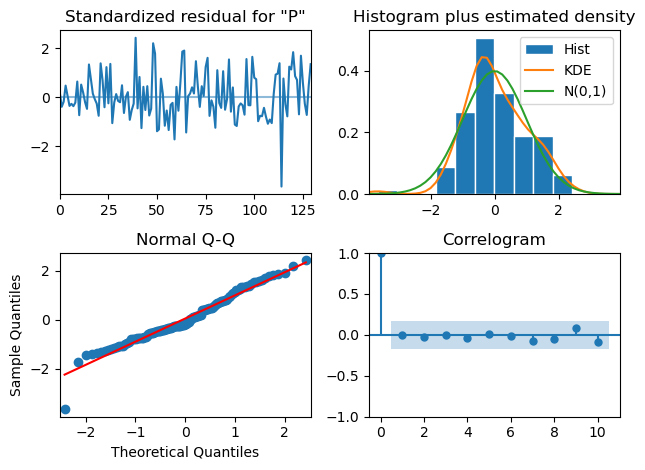

In [399]:
ARIMA_model.plot_diagnostics()
plt.tight_layout()

**INTERIM CONCLUSION**

Residuals’ diagnostics of the ARIMA(11,2,3) model. 

- top-left plot, the residuals have no trend with a variance that seems fairly constant over time, which resembles the behavior of white
noise.
- top-right plot shows the distribution of the residuals, which approaches a normal distribution,
despite the unusual peak. This is further confirmed by the Q-Q plot.
- bottom left, which displays a fairly straight line that lies on y = x.
- the correlogram in the bottom-right plot shows no significant autocorrelation coefficients after lag 0, which is exactly like white noise. From this analysis, the residuals resemble white noise.


In [400]:
# Apply ljung-Box test on the last 10 lags

residuals= ARIMA_model.resid
lbvalue= acorr_ljungbox(residuals, np.arange(1,11,1))

print(list(lbvalue['lb_pvalue']))

[0.010453768184087926, 0.03538669788577517, 0.0730926771578761, 0.10100244247568246, 0.13563762045031683, 0.19228034755966686, 0.21915850260737796, 0.28436836515608654, 0.3717626824563961, 0.31721869882347614]


**INTERIM CONCLUSION**

The returned p-values are all greater than 0.05 except for the first two values. 

This means that, according to the Ljung-Box test, we reject the null hypothesis with a 5%
chance of being wrong, since we set our significance boundary to 0.05. However, the
third value and onwards are all greater than 0.05, so we reject the null hypothesis, concluding
that the residuals are uncorrelated starting at lag 3.

This is an interesting situation to dissect, because the graphical analysis of the
residuals leads us to conclude that they resemble white noise, but the Ljung-Box test
points to some correlation at lags 1 and 2. This means that our ARIMA model is not
capturing all the information from the data.

The Ljung-Box test is really
telling us that our model is not perfect, but that’s okay, because part of this exercise is
to compare the performance of ARIMA and SARIMA and demonstrate that SARIMA
is the way to go when dealing with seasonal data.

#### Define Baseline Model

As we wish to predict a full year of monthly air passengers,
using the last 12 months of data as our test set. The baseline model is the naive seasonal
forecast, where we simply use the number of air passengers for each month of
1959 as a forecast for each month of 1960.

In [403]:
test['naive_seasonal']= df['Passengers'].iloc[120:132].values
test

/tmp/ipykernel_1507/1865596012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal']= df['Passengers'].iloc[120:132].values


,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [404]:
test['ARIMA_pred']= ARIMA_model.get_prediction(132,143).predicted_mean
test

/tmp/ipykernel_1507/2788338917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred']= ARIMA_model.get_prediction(132,143).predicted_mean


,Month,Passengers,naive_seasonal,ARIMA_pred
132,1960-01,417,360,422.354423
133,1960-02,391,342,410.643428
134,1960-03,419,406,461.833721
135,1960-04,461,396,457.813478
136,1960-05,472,420,481.685497
137,1960-06,535,472,531.087265
138,1960-07,622,548,606.149726
139,1960-08,606,559,615.468590
140,1960-09,508,463,525.627324
141,1960-10,461,407,467.133053


### SARIMA

Hopefully the SARIMA model will perform better, since it
can capture seasonal information, and we know that our dataset exhibits clear seasonality

#### Verify Stationarity

In [409]:
ad_fuller_res= adfuller(df['Passengers'])

print(f'ADF stat: {ad_fuller_res[0]:.2f}')
print(f'p-val: {ad_fuller_res[1]:.2f}')

ADF stat: 0.82
p-val: 0.99


In [410]:
df_diff= np.diff(df['Passengers'],n=1)
ad_fuller_res= adfuller(df_diff)

print(f'ADF stat: {ad_fuller_res[0]:.2f}')
print(f'p-val: {ad_fuller_res[1]:.3f}')

ADF stat: -2.83
p-val: 0.054


**INTERIM CONCLUSION**

This returns an ADF statistic of –2.83 and a p-value of 0.054. Since the p-value is
greater than 0.05, we cannot reject the null hypothesis, and the series is still nonstationary.

As we know that our timeseries is seasonal therefore, let’s apply a seasonal difference and test for stationarity.

In [411]:
# Since we have monthly data m=12, so the seasonal difference between 2 values that are 12 timesetps apart
df_diff_seasonal= np.diff(df_diff, n=12)
ad_fuller_res= adfuller(df_diff_seasonal)

print(f'ADF stat: {ad_fuller_res[0]:.2f}')
print(f'p-val: {ad_fuller_res[1]:.3f}')

ADF stat: -17.62
p-val: 0.000


**INTERIM CONCLUSION**

With a large and
negative ADF statistic and a p-value smaller than 0.05, we can reject the null hypothesis
and consider the transformed series as stationary. 

Therefore, we performed one
round of differencing, meaning that d = 1, and one round of seasonal differencing,
meaning that D = 1.

#### Search order

In [424]:
p= range(0,4,1)
q= range(0,4,1)
P= range(0,4,1)
Q= range(0,4,1)
d=1
D=1
s=12
SARIMA_order_list= list(product(p,q,P,Q))
len(SARIMA_order_list)

256

In [425]:
%%time
# ~11 min
SARIMA_result_df= optimize_SARIMA(train, SARIMA_order_list,d,D,s)
SARIMA_result_df

Optimizing Model: 100%|█████████████████████████████████████████████████████| 256/256 [11:51<00:00,  2.78s/it]

CPU times: user 3h 8min 50s, sys: 4.62 s, total: 3h 8min 54s
Wall time: 11min 51s


,"(p,d,q)(P,D,Q)",AIC
0,"(1, 1, 1, 3, 1, 2)",0.95
1,"(2, 1, 1, 1, 1, 2)",8.92
2,"(2, 1, 1, 1, 1, 3)",8.94
3,"(2, 1, 1, 2, 1, 3)",8.94
4,"(1, 1, 0, 1, 1, 2)",8.94
...,...,...
251,"(0, 1, 0, 2, 1, 0)",9.07
252,"(0, 1, 0, 3, 1, 2)",9.07
253,"(0, 1, 0, 0, 1, 3)",9.09
254,"(0, 1, 0, 3, 1, 0)",9.09


#### Resid Analysis

In [429]:
SARIMA_model= SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12),simple_differencing=False).fit(disp=False)

/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zai11972/miniconda3/envs/tensrnv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


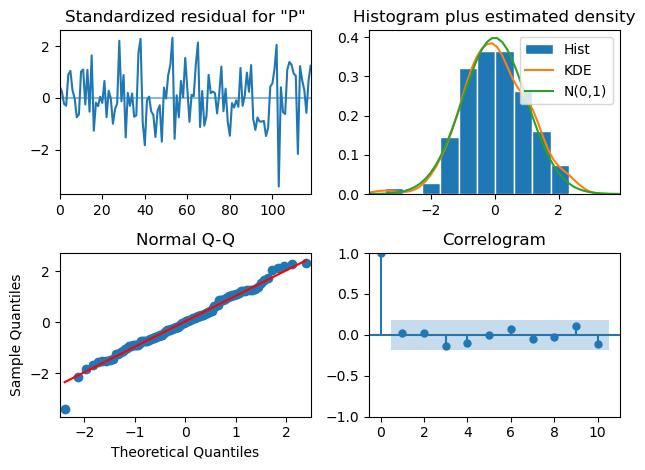

In [430]:
SARIMA_model.plot_diagnostics()
plt.tight_layout()

**INTERIM CONCLUSION**

The results show that our residuals are completely random, which is exactly what we
are looking for in a good model.

In [433]:
test['SARIMA_pred']= SARIMA_model.get_prediction(132,143).predicted_mean

/tmp/ipykernel_1507/956106934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred']= SARIMA_model.get_prediction(132,143).predicted_mean


In [434]:
test

,Month,Passengers,naive_seasonal,ARIMA_pred,SARIMA_pred
132,1960-01,417,360,422.354423,418.567823
133,1960-02,391,342,410.643428,399.671061
134,1960-03,419,406,461.833721,461.430450
135,1960-04,461,396,457.813478,451.564778
136,1960-05,472,420,481.685497,473.910945
137,1960-06,535,472,531.087265,538.824114
138,1960-07,622,548,606.149726,612.582523
139,1960-08,606,559,615.468590,624.819052
140,1960-09,508,463,525.627324,520.310069
141,1960-10,461,407,467.133053,463.007110


In [431]:
residuals= SARIMA_model.resid

lbval= acorr_ljungbox(residuals, np.arange(1,11,1))

print(list(lbval['lb_pvalue']))

[0.9438247189386726, 0.688932946367273, 0.7964780340947843, 0.8741162234109123, 0.9201993050305007, 0.9444420690162126, 0.9412357469738178, 0.9512728735020843, 0.9742377953051742, 0.8941708390175679]


**INTERIM CONCLUSION**

The returned p-values are all greater than 0.05. Therefore, we do not reject the null
hypothesis, and we conclude that the residuals are independent and uncorrelated,
just like white noise.

Which is much better in compare with our results on ARIMA

### ARIMA vs SARIMA

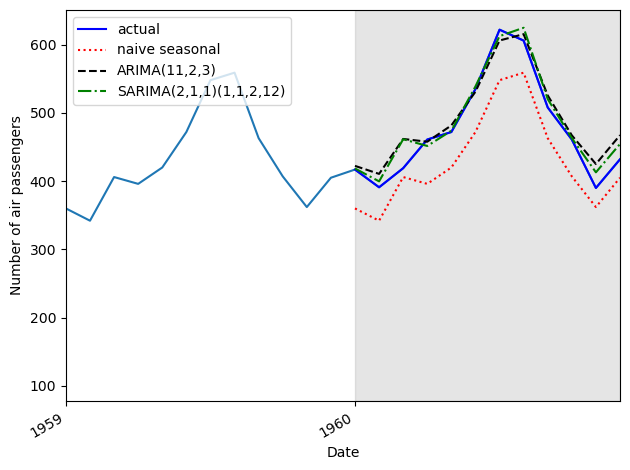

In [436]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()

In [437]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [438]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])


9.987532920823485 3.8411484313337976 2.869824897099806


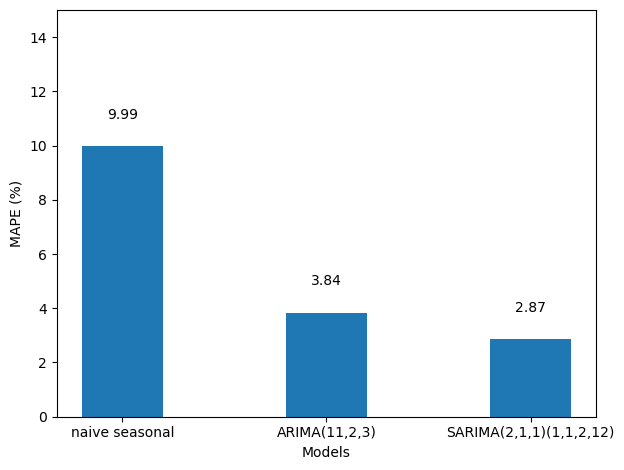

In [440]:
ig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

**INTERIM CONCLUSIONS**

SARIMA model is the best-performing method for this situation. This makes sense, since our
dataset had clear seasonality, and the SARIMA model is built to use the seasonal properties
of time series to make forecasts.